# Data import

**스토리텔링**

결측치를 처리하고 상품가격별로 cost에 대한 민감도가 낮지 않을까 가설을 세움
기준은 5만원 단위로 나눈다음에 차이를 봤다
미세하지만 상품가격대가 올라가면 비용을 안썼을때 순위가 비용을 썼을때 순위와 격차가 줄어드는걸 볼수있다
차이 자체가 미세해서 가격에 따른 cost에 민감도가 확 낮다고 볼수는 없다
다만 확실히 상품가격이 올라가면 무료배달 비율이 높아지는건 알수있었다

상품가격이 높아지면 질수록 가구/인테리어 비중이 확 올라가는것도 다른카테고리에 비해 가구/인테리어에 상품가격이 비싼 제품들이 많은걸 알수있다

재미있는건 상관관계였다

5만원 이하의 제품들에서는 클릭과 코스트의 상관관계가 높았지만 5~10만원대에서는 상관관계가 낮아지고 클릭, 코스트와 노출도가 상관관계가 높아졌다
이러한 것처럼 
구간별로 특징적인데 만약 코스트를 사용할거면 상관관계가 높은 구간별로 우선순위를 두는것도 좋은 생각이고 만약 적극적으로 코스트를 써서 팔아야하는 제품이라면 코스트효율이 좋은 구간대로 상품가격을 측정하는것도 좋은 방법이지 않을까 싶다

 --

rank별로 특징을 찾아봤다
윈도우 유저가 많다는걸 생각하여
네이버 쇼핑 홈페이지 기준으로 분류했고 페이지마다 광고가 6개 들어가며 40개보기가 디폴트값인것같았다
20개보기, 40개보기, 60개보기, 80개 보기가 있어고
거기에 광고 6개를 포함하여 26개, 46개 이렇게 보여줬다
광고는 상위 3개
중간에 3개 이렇게 6개가 들어가는것 같았다

순위가 1위에 가까울수록 광고가 많지는 않았지만 코스트는 높은걸로봐서는 광고 개수보다는 코스트를 많이쓰는걸 알수있다

특별한 특징을 찾을수는 없었지만 순위가 1위에 가까울수록 상품가격이 높다는건 조금 특이한 특징이지 않을까 싶다

특별한 특징을 찾아내지 못해 극단적으로 그룹을 나누어 살펴보았다

한페이지에 들어가는 26개와 그렇지 않은 그룹으로 나누어서 보았다

비용차이가 많이난건 당연한 결과인것같다
배달비 유무가 생각보다 차이나는걸 보면 배달비 유무도 순위를 1위에 가깝게 하는데 좋은 인사이트인것같고 상품가격이 1위에 가까울수록 높은게 의외의 결과이다

카테고리1의 비율을 우선 잘 기억해 두는것이 좋겠다
1등 가구/인테리어 71%
2등 생활/건강 23%

조금 더 극단적으로 광고3개와 홈페이지 기준 한눈에 들어오는 상품 4개를 합쳐 7개기준으로 봤고 당연한 결과들이 눈에들어왔다

--

카테고리별로 특징을 살펴보았다
전체 데이터 클릭의 평균보다 높은 카테고리는
가구/인테리어 말고는 평균 클릭수보다 높았다

코스트가 재미있었는데 패션의류쪽에서 평균보다 2배 가까운 코스트를 사용하는것이 재미있었다
카테고리 비율을 보면 가구/인테리어가 많은데 코스트는 패션의류쪽이 가장높은것이 특징이였다

주어진 데이터 안에서 패션의류쪽에 가장 진심인것 같다는 생각이들었다

광고별로 데이터를 분류하여 카테고리별로 보았다

재미있는건 식품은 클릭이 0인것이다...
코스트는 광고별로 보면 패션의류쪽에서 평균보다 4배가까운 비용을 사용했다
코스트는 4배 클릭률은 2배 데이터 상으로 패션의류의 진심인게 느껴진다






In [78]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.font_manager as fm
import seaborn as sns
import datetime as dt
import matplotlib.font_manager as fm
import random
import pickle

from matplotlib import gridspec
from scipy import stats

In [5]:
# BASE_DIR = Path(__name__).resolve().parent.parent
FILES_DIR = '../files/'
bidding_df = pd.read_csv(FILES_DIR + 'bidding_results.csv')

In [6]:
fm.get_fontconfig_fonts()
font_location = 'C:\\WINDOWS\\Fonts\\malgun.ttf' # For Windows
font_name = fm.FontProperties(fname=font_location).get_name()
matplotlib.rc('font', family=font_name)

C:\Users\bongkyun\AppData\Local\Temp\ipykernel_13288\2582751676.py:1: MatplotlibDeprecationWarning: 
The get_fontconfig_fonts function was deprecated in Matplotlib 3.5 and will be removed two minor releases later.
  fm.get_fontconfig_fonts()


In [7]:
bidding = bidding_df.copy()

# Null Value Processing

In [8]:
# column describe 
def descriptive_info(bidding):
    number_of_cells = bidding.count(axis=0, level=None, numeric_only=False)
    print('Total number of cells the datafile has: \n' + str(number_of_cells))
    print('\n')
    print('Printing descriptive statistics...\n\n', bidding.describe())

descriptive_info(bidding)

Total number of cells the datafile has: 
index              1337088
Impression         1337088
Click              1337088
Cost               1337088
Sum of AD rank     1337078
Bid                1337088
Price(PC)          1337088
Price(Mobile)      1337088
Delivery Fee       1337088
Category Name 1    1337088
Category Name 2    1337088
Category Name 3    1331221
Category Name 4     930132
date               1337088
dtype: int64


Printing descriptive statistics...

               index    Impression         Click          Cost  Sum of AD rank  \
count  1.337088e+06  1.337088e+06  1.337088e+06  1.337088e+06    1.337078e+06   
mean   5.167098e+06  4.412753e+01  7.189467e-01  1.800053e+02    1.138271e+01   
std    2.655813e+06  3.434510e+02  3.423456e+00  1.772706e+03    1.323231e+01   
min    2.578600e+04  0.000000e+00  0.000000e+00  0.000000e+00    1.000000e+00   
25%    3.300168e+06  3.000000e+00  0.000000e+00  0.000000e+00    3.706897e+00   
50%    4.637081e+06  1.000000e+01  0.000000

In [9]:
# bidding 날짜 datetime으로 만들기
def _trans_date_time(bidding):
    bidding.index = pd.to_datetime(bidding['date'], format='%Y%m%d')
    bidding.drop('date', axis=1, inplace=True)
    return bidding

_trans_date_time(bidding)

,index,Impression,Click,Cost,Sum of AD rank,Bid,Price(PC),Price(Mobile),Delivery Fee,Category Name 1,Category Name 2,Category Name 3,Category Name 4
date,,,,,,,,,,,,,
2022-10-31,3575092,3,0,0.0,3.000000,50,165900,165900,0,가구/인테리어,침실가구,장롱/붙박이장,드레스룸
2022-10-31,3575637,6,0,0.0,3.333333,50,10900,10900,0,가구/인테리어,인테리어소품,아로마/캔들용품,아로마방향제/디퓨저
2022-10-31,4129259,7,0,0.0,8.000000,50,255000,255000,-1,가구/인테리어,거실가구,소파,패브릭소파
2022-10-31,4131479,36,3,150.0,4.416667,140,190000,190000,20000,가구/인테리어,아동/주니어가구,책상의자세트,NaN
2022-10-31,4131482,224,0,0.0,5.696429,50,129000,129000,0,가구/인테리어,아동/주니어가구,책상,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-01-03,2566795,5,0,0.0,13.200000,500,19900,19900,0,가구/인테리어,인테리어소품,아로마/캔들용품,아로마방향제/디퓨저
2023-01-03,2566880,3,0,0.0,17.000000,500,23900,23900,3000,생활/건강,문구/사무용품,이벤트/파티용품,데코용품
2023-01-03,2566881,1,0,0.0,8.000000,500,2500,2500,3000,가구/인테리어,인테리어소품,기타장식용품,NaN


In [10]:
# CTR = 클릭률
# CPC = 클릭당 비용
# CPM = 1000회 노출당 비용
# Sum of AD rank = 반올림
bidding["CTR"] = (bidding["Click"]/bidding["Impression"]) * 100
bidding["CPC"] = (bidding["Cost"]/bidding["Click"])
bidding["CPM"] = (bidding["Cost"]/1000)
bidding['Sum of AD rank'] = bidding['Sum of AD rank'].round(0)

In [11]:
bidding_drop_null = bidding.copy()
bidding_drop_null['Category Name 4'].fillna('null_cat4', inplace = True)
bidding_drop_null['CPC'].fillna(0, inplace = True)
bidding_drop_null.dropna(axis = 0, inplace = True)
print(bidding_drop_null.isnull().sum().sort_values(ascending=False)) # null값 퍼센트로 표현

index              0
Impression         0
Click              0
Cost               0
Sum of AD rank     0
Bid                0
Price(PC)          0
Price(Mobile)      0
Delivery Fee       0
Category Name 1    0
Category Name 2    0
Category Name 3    0
Category Name 4    0
CTR                0
CPC                0
CPM                0
dtype: int64


In [12]:
bidding_drop_null

,index,Impression,Click,Cost,Sum of AD rank,Bid,Price(PC),Price(Mobile),Delivery Fee,Category Name 1,Category Name 2,Category Name 3,Category Name 4,CTR,CPC,CPM
date,,,,,,,,,,,,,,,,
2022-10-31,3575092,3,0,0.0,3.0,50,165900,165900,0,가구/인테리어,침실가구,장롱/붙박이장,드레스룸,0.000000,0.0,0.00
2022-10-31,3575637,6,0,0.0,3.0,50,10900,10900,0,가구/인테리어,인테리어소품,아로마/캔들용품,아로마방향제/디퓨저,0.000000,0.0,0.00
2022-10-31,4129259,7,0,0.0,8.0,50,255000,255000,-1,가구/인테리어,거실가구,소파,패브릭소파,0.000000,0.0,0.00
2022-10-31,4131479,36,3,150.0,4.0,140,190000,190000,20000,가구/인테리어,아동/주니어가구,책상의자세트,null_cat4,8.333333,50.0,0.15
2022-10-31,4131482,224,0,0.0,6.0,50,129000,129000,0,가구/인테리어,아동/주니어가구,책상,null_cat4,0.000000,0.0,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-01-03,2566795,5,0,0.0,13.0,500,19900,19900,0,가구/인테리어,인테리어소품,아로마/캔들용품,아로마방향제/디퓨저,0.000000,0.0,0.00
2023-01-03,2566880,3,0,0.0,17.0,500,23900,23900,3000,생활/건강,문구/사무용품,이벤트/파티용품,데코용품,0.000000,0.0,0.00
2023-01-03,2566881,1,0,0.0,8.0,500,2500,2500,3000,가구/인테리어,인테리어소품,기타장식용품,null_cat4,0.000000,0.0,0.00


# Data pickle load

In [79]:
# save and compress.
with open('bidding_drop_null.pickle', 'wb') as f:
    pickle.dump(bidding_drop_null, f, pickle.HIGHEST_PROTOCOL)

In [80]:
# load
with open('bidding_drop_null.pickle', 'rb') as f:
    bidding_drop_null = pickle.load(f)

In [82]:
bidding_drop_null

,index,Impression,Click,Cost,Sum of AD rank,Bid,Price(PC),Price(Mobile),Delivery Fee,Category Name 1,Category Name 2,Category Name 3,Category Name 4,CTR,CPC,CPM
date,,,,,,,,,,,,,,,,
2022-10-31,3575092,3,0,0.0,3.0,50,165900,165900,0,가구/인테리어,침실가구,장롱/붙박이장,드레스룸,0.000000,0.0,0.00
2022-10-31,3575637,6,0,0.0,3.0,50,10900,10900,0,가구/인테리어,인테리어소품,아로마/캔들용품,아로마방향제/디퓨저,0.000000,0.0,0.00
2022-10-31,4129259,7,0,0.0,8.0,50,255000,255000,-1,가구/인테리어,거실가구,소파,패브릭소파,0.000000,0.0,0.00
2022-10-31,4131479,36,3,150.0,4.0,140,190000,190000,20000,가구/인테리어,아동/주니어가구,책상의자세트,null_cat4,8.333333,50.0,0.15
2022-10-31,4131482,224,0,0.0,6.0,50,129000,129000,0,가구/인테리어,아동/주니어가구,책상,null_cat4,0.000000,0.0,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-01-03,2566795,5,0,0.0,13.0,500,19900,19900,0,가구/인테리어,인테리어소품,아로마/캔들용품,아로마방향제/디퓨저,0.000000,0.0,0.00
2023-01-03,2566880,3,0,0.0,17.0,500,23900,23900,3000,생활/건강,문구/사무용품,이벤트/파티용품,데코용품,0.000000,0.0,0.00
2023-01-03,2566881,1,0,0.0,8.0,500,2500,2500,3000,가구/인테리어,인테리어소품,기타장식용품,null_cat4,0.000000,0.0,0.00


# Price 구간별 Cost 민감도에 따른 Rank

In [81]:
price_down_5 = bidding_drop_null[bidding_drop_null['Price(PC)'] <= 50000]

price_5_10 = bidding_drop_null[(bidding_drop_null['Price(PC)'] > 50000) & (bidding_drop_null['Price(PC)'] < 100000)]

price_10_15 = bidding_drop_null[(bidding_drop_null['Price(PC)'] > 100000) & (bidding_drop_null['Price(PC)'] < 150000)]

price_15_20 = bidding_drop_null[(bidding_drop_null['Price(PC)'] > 150000) & (bidding_drop_null['Price(PC)'] < 200000)]

price_up_20 = bidding_drop_null[bidding_drop_null['Price(PC)'] >= 200000]

In [14]:
# 수치표현
# 그래프표현
def price_Analysis(df):
        
    print('비용평균')
    print(df['Cost'].mean())
    print('-' * 50)
    print('\n')
    
    cost_non_zero = df[df['Cost'] != 0]
    
    
    print(f'코스트 썼을때 평균 순위 : {cost_non_zero["Sum of AD rank"].mean()}')

    cost_zero = df[df['Cost'] == 0]

    print(f'코스트 안 썼을때 평균 순위 : {cost_zero["Sum of AD rank"].mean()}')
    print('-' * 50)
    print('\n')
  

    print("광고숫자비율")
    print((len(list(set(df['index'].values))) / len(df))*100)
    print('-' * 50)
    print('\n')
    
    
    rank_del_zero = df[df['Delivery Fee'] <= 0]
    rank_del_non_zero = df[df['Delivery Fee'] > 0]
    print('배달비 없음 비율')
    print((rank_del_zero.shape[0] / df['Delivery Fee'].shape[0]*100))
    print('\n')
    print('배달비 있음 비율')
    print((rank_del_non_zero.shape[0] / df['Delivery Fee'].shape[0]*100))  
    print('-' * 50)
    print('\n')
    

    print('코스트비율')
    print(df['Cost'].value_counts(normalize=True))
    print('-' * 50)
    print('\n')
    
    plt.figure(figsize=(28, 12))
    plt.subplot(4, 1, 1)
    print('코스트')
    display(cost_non_zero['Cost'].describe())
    plt.hist(cost_non_zero['Cost'], bins=20)
    plt.title('cost_non_zero')
    plt.xticks()
    
    
    print('-' * 50)
    print('\n')
    
    
    plt.subplot(4, 1, 2)
    print('카테고리1')
    display(df['Category Name 1'].value_counts(normalize=True))
    sns.countplot(x=df['Category Name 1'], data=df)
    plt.title('Category Name 1')
    plt.xticks()
    
    
    print('-' * 50)
    print('\n')
    
    
    plt.subplot(4, 1, 3)
    print('코스트 있음 , 순위')
    display(cost_non_zero['Sum of AD rank'].describe())
    plt.hist(cost_non_zero['Sum of AD rank'], bins=20)
    plt.title('cost_non_zero')
    plt.xticks()
    
    
    print('-' * 50)
    print('\n')
    
    
    plt.subplot(4, 1, 4)
    print('코스트 없음 , 순위')
    display(cost_zero['Sum of AD rank'].describe())
    plt.hist(cost_zero['Sum of AD rank'], bins=20)
    plt.title('cost_zero')
    plt.xticks()

    

비용평균
167.80673792112006
--------------------------------------------------


코스트 썼을때 평균 순위 : 6.01917086348931
코스트 안 썼을때 평균 순위 : 13.595440104968716
--------------------------------------------------


광고숫자비율
3.8164244239623955
--------------------------------------------------


배달비 없음 비율
40.11324425725326


배달비 있음 비율
59.88675574274674
--------------------------------------------------


코스트비율
0.0        0.759737
50.0       0.051082
100.0      0.017548
150.0      0.009396
200.0      0.006845
             ...   
11830.0    0.000002
8910.0     0.000002
13810.0    0.000002
12050.0    0.000002
9060.0     0.000002
Name: Cost, Length: 1739, dtype: float64
--------------------------------------------------


코스트


count    149915.000000
mean        698.428176
std        3547.304425
min          50.000000
25%          90.000000
50%         210.000000
75%         500.000000
max      246040.000000
Name: Cost, dtype: float64

--------------------------------------------------


카테고리1


가구/인테리어    0.506722
생활/건강      0.417855
출산/육아      0.026109
스포츠/레저     0.015120
패션잡화       0.012150
화장품/미용     0.010542
디지털/가전     0.007847
패션의류       0.003034
여가/생활편의    0.000372
식품         0.000250
Name: Category Name 1, dtype: float64

--------------------------------------------------


코스트 있음 , 순위


count    149915.000000
mean          6.019171
std           6.244767
min           1.000000
25%           2.000000
50%           4.000000
75%           7.000000
max          98.000000
Name: Sum of AD rank, dtype: float64

--------------------------------------------------


코스트 없음 , 순위


count    474046.000000
mean         13.595440
std          15.471149
min           1.000000
25%           4.000000
50%           8.000000
75%          16.000000
max         100.000000
Name: Sum of AD rank, dtype: float64

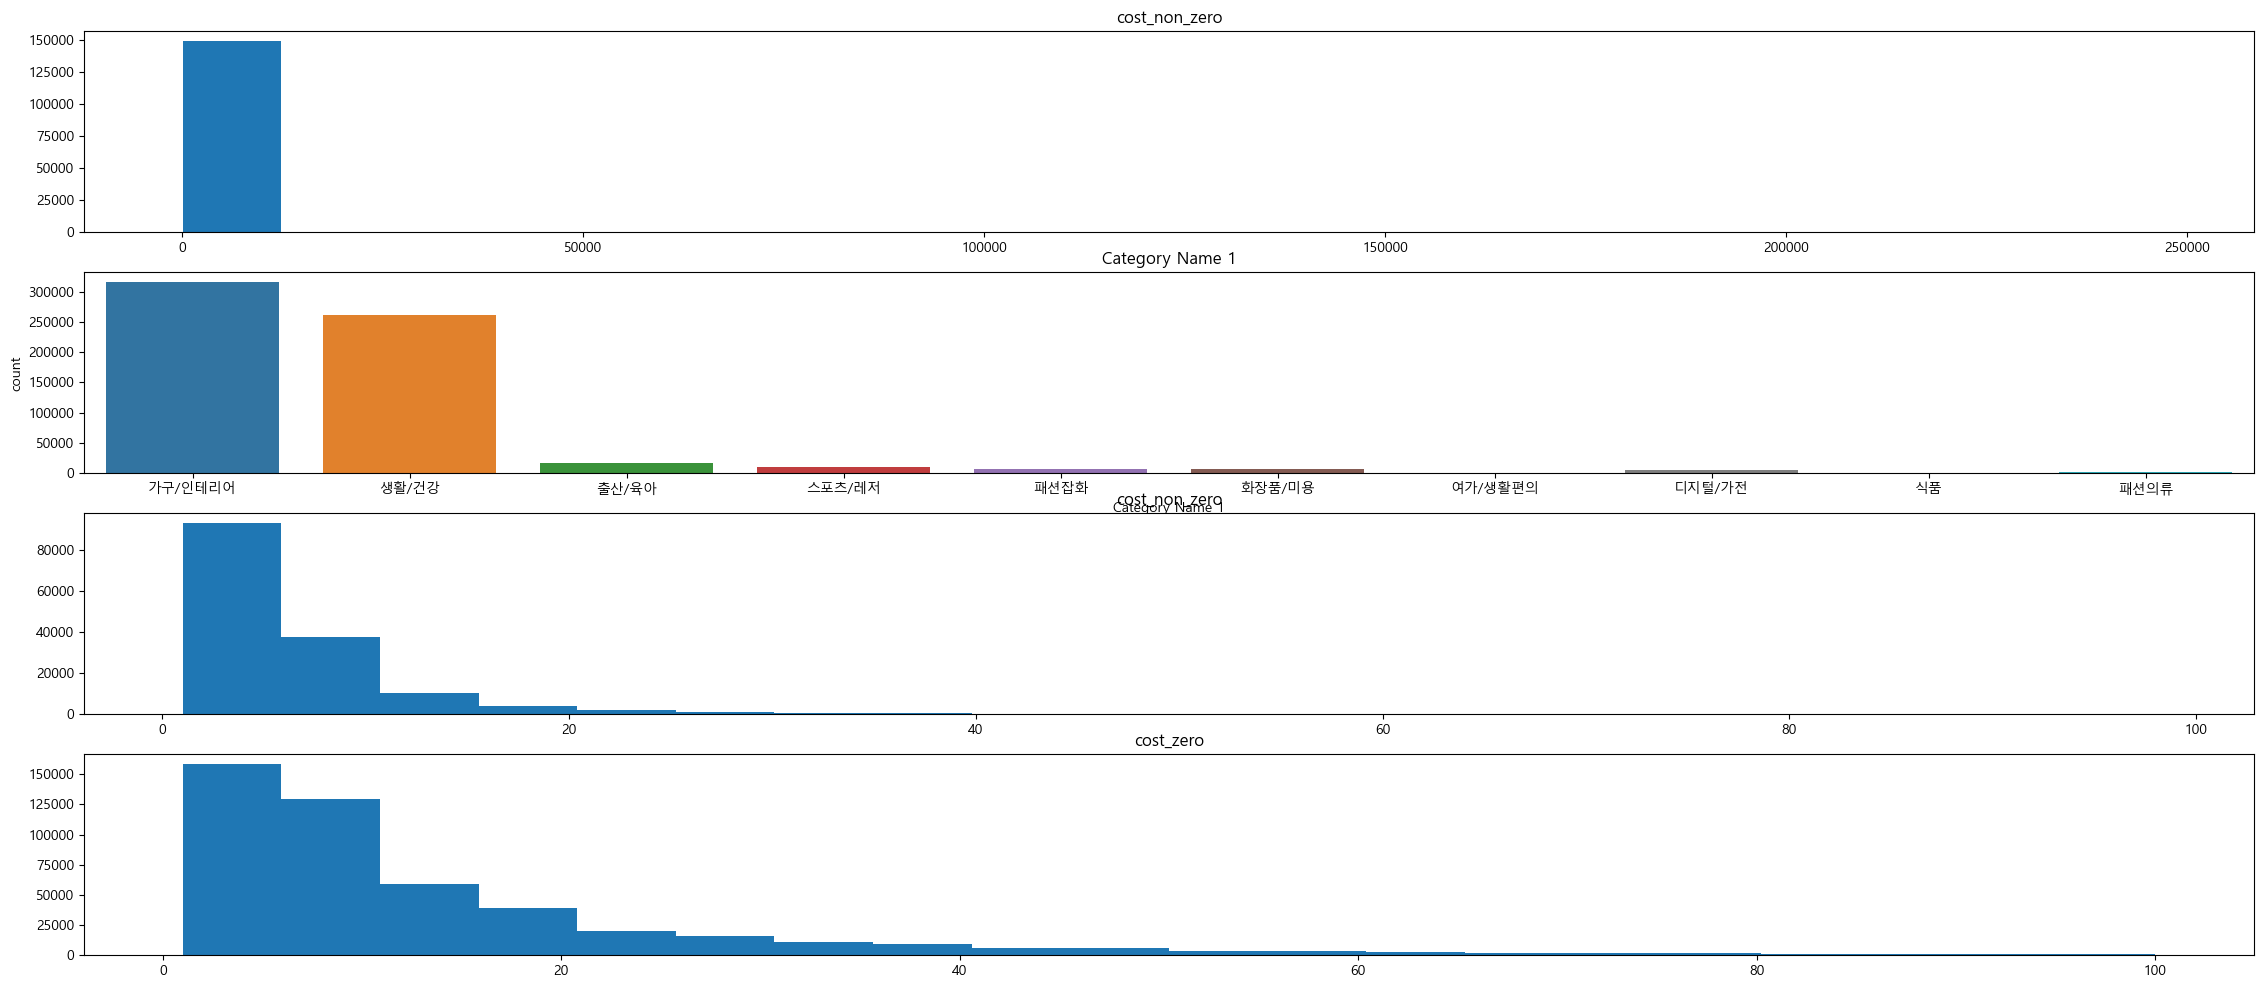

In [15]:
price_Analysis(price_down_5)

비용평균
169.75988080378508
--------------------------------------------------


코스트 썼을때 평균 순위 : 6.468736928072028
코스트 안 썼을때 평균 순위 : 13.20863936834374
--------------------------------------------------


광고숫자비율
3.7204414601536326
--------------------------------------------------


배달비 없음 비율
72.29230700919132


배달비 있음 비율
27.70769299080867
--------------------------------------------------


코스트비율
0.0        0.752318
50.0       0.051270
100.0      0.017238
150.0      0.008792
200.0      0.006478
             ...   
9010.0     0.000005
7370.0     0.000005
10850.0    0.000005
86540.0    0.000005
17610.0    0.000005
Name: Cost, Length: 1053, dtype: float64
--------------------------------------------------


코스트


count     50203.000000
mean        685.393303
std        3481.783996
min          50.000000
25%          90.000000
50%         230.000000
75%         500.000000
max      325300.000000
Name: Cost, dtype: float64

--------------------------------------------------


카테고리1


가구/인테리어    0.803943
생활/건강      0.147180
출산/육아      0.022744
스포츠/레저     0.016912
화장품/미용     0.003602
디지털/가전     0.002309
여가/생활편의    0.001495
패션의류       0.000878
패션잡화       0.000671
식품         0.000266
Name: Category Name 1, dtype: float64

--------------------------------------------------


코스트 있음 , 순위


count    50203.000000
mean         6.468737
std          6.288642
min          1.000000
25%          3.000000
50%          5.000000
75%          8.000000
max         98.000000
Name: Sum of AD rank, dtype: float64

--------------------------------------------------


코스트 없음 , 순위


count    152488.000000
mean         13.208639
std          14.539568
min           1.000000
25%           4.000000
50%           8.000000
75%          16.000000
max         100.000000
Name: Sum of AD rank, dtype: float64

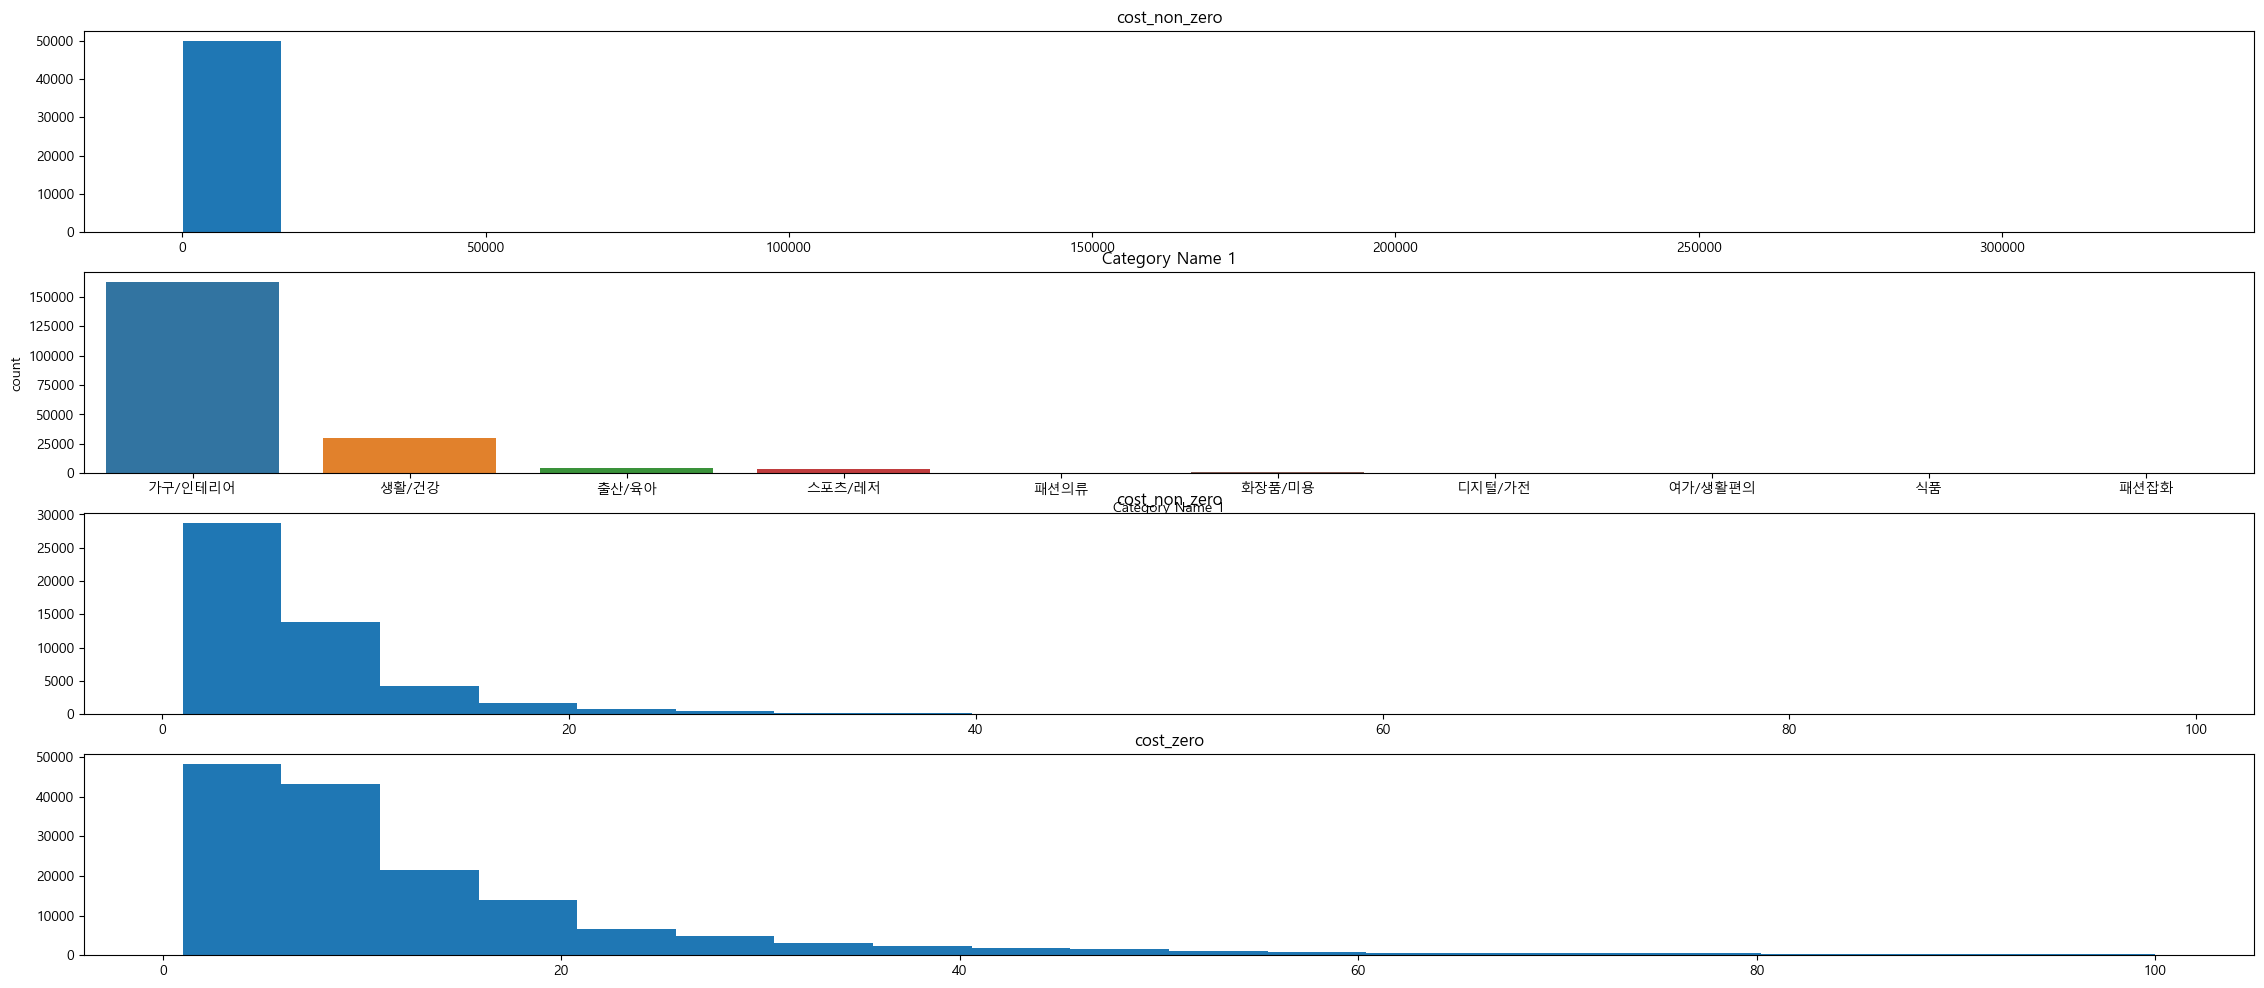

In [16]:
price_Analysis(price_5_10)

비용평균
176.7522275674545
--------------------------------------------------


코스트 썼을때 평균 순위 : 6.805257416335293
코스트 안 썼을때 평균 순위 : 13.58261623567634
--------------------------------------------------


광고숫자비율
3.8761765321062542
--------------------------------------------------


배달비 없음 비율
86.22798577703409


배달비 있음 비율
13.772014222965906
--------------------------------------------------


코스트비율
0.0        0.762251
50.0       0.042836
100.0      0.014097
150.0      0.007956
200.0      0.005806
             ...   
6180.0     0.000008
7770.0     0.000008
28530.0    0.000008
14250.0    0.000008
26380.0    0.000008
Name: Cost, Length: 855, dtype: float64
--------------------------------------------------


코스트


count     28417.000000
mean        743.439139
std        3118.644716
min          50.000000
25%         100.000000
50%         260.000000
75%         580.000000
max      185690.000000
Name: Cost, dtype: float64

--------------------------------------------------


카테고리1


가구/인테리어    0.886785
생활/건강      0.082041
출산/육아      0.013587
스포츠/레저     0.012039
디지털/가전     0.001824
여가/생활편의    0.001732
패션의류       0.001723
화장품/미용     0.000167
패션잡화       0.000100
Name: Category Name 1, dtype: float64

--------------------------------------------------


코스트 있음 , 순위


count    28417.000000
mean         6.805257
std          6.476787
min          1.000000
25%          3.000000
50%          5.000000
75%          8.000000
max         93.000000
Name: Sum of AD rank, dtype: float64

--------------------------------------------------


코스트 없음 , 순위


count    91108.000000
mean        13.582616
std         14.520047
min          1.000000
25%          5.000000
50%          9.000000
75%         16.000000
max        100.000000
Name: Sum of AD rank, dtype: float64

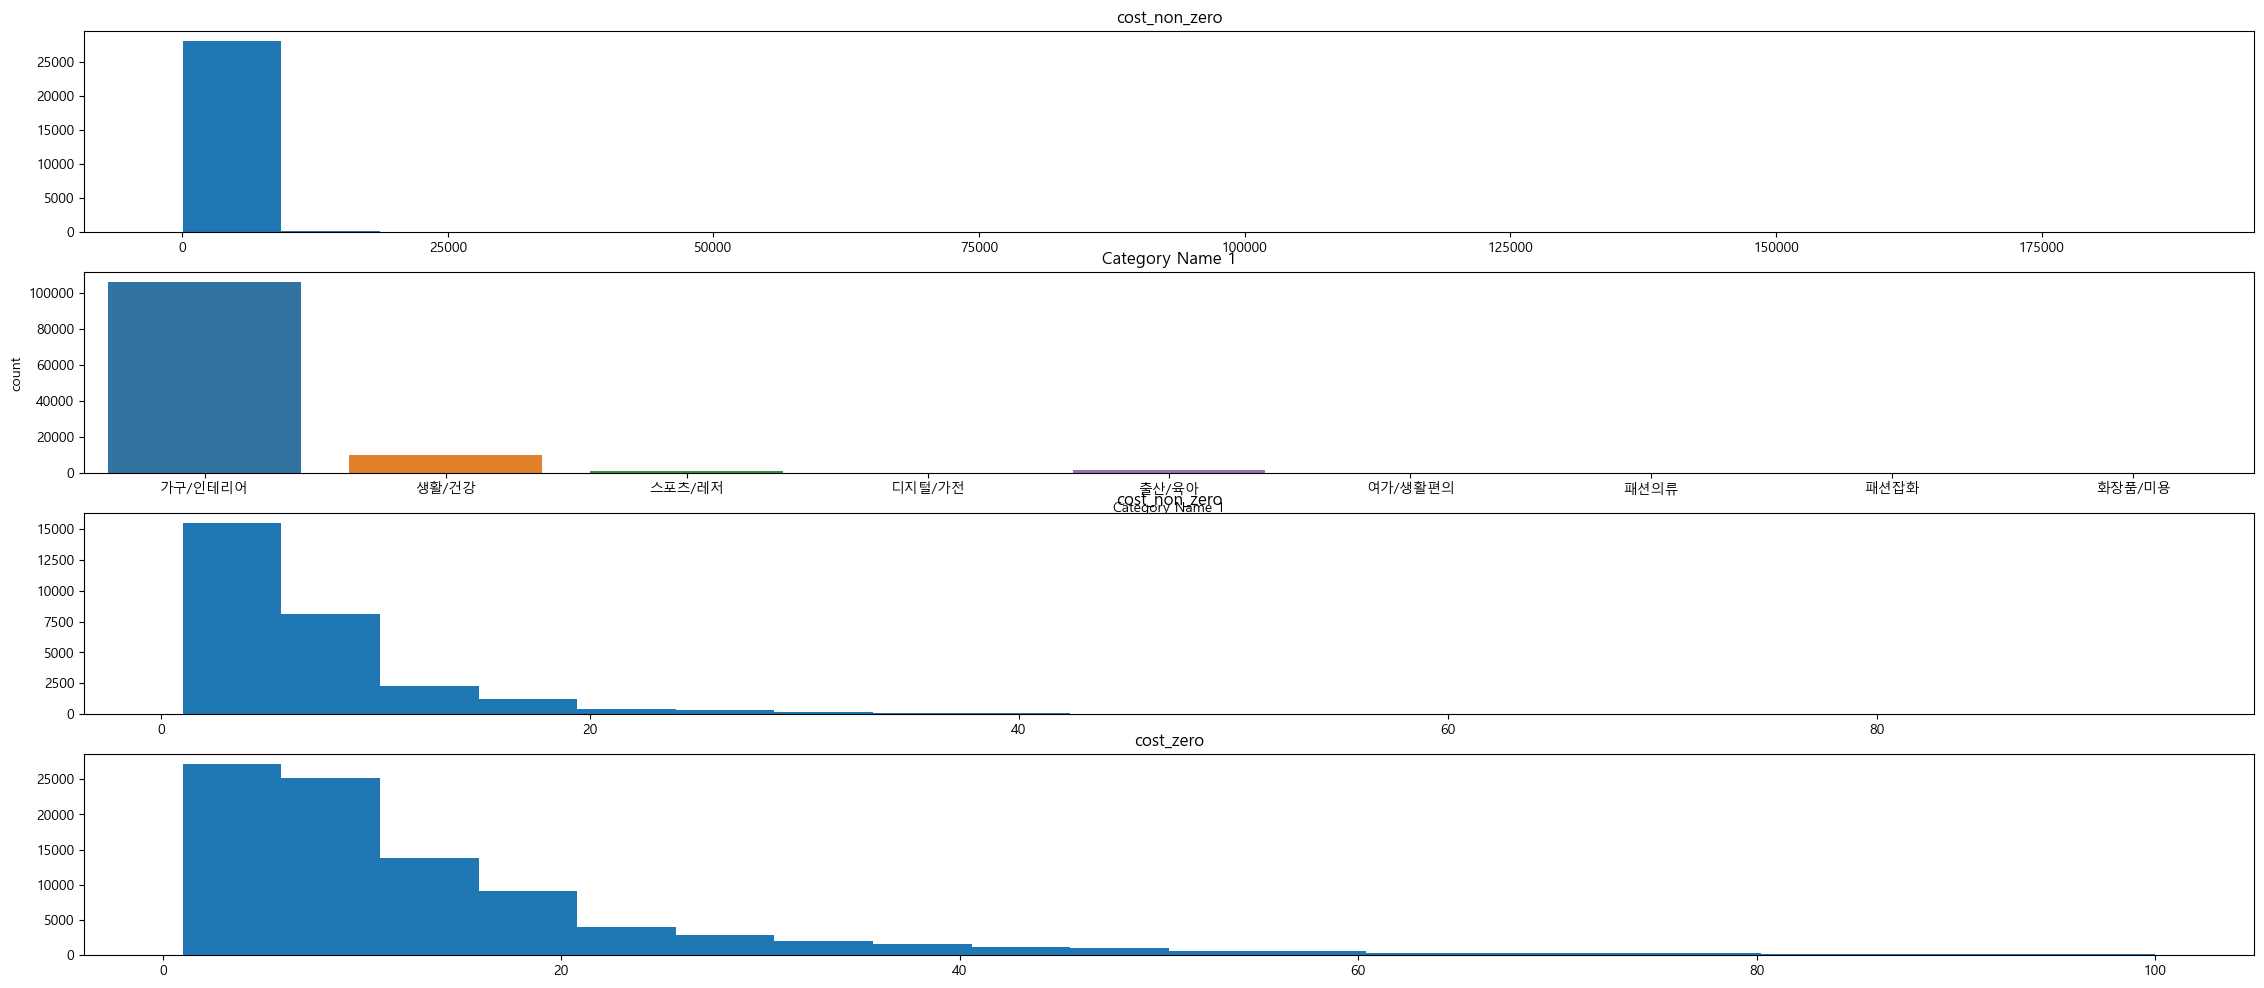

In [17]:
price_Analysis(price_10_15)

비용평균
203.27396972012716
--------------------------------------------------


코스트 썼을때 평균 순위 : 6.766107397808393
코스트 안 썼을때 평균 순위 : 13.122434039064101
--------------------------------------------------


광고숫자비율
3.8054734137400184
--------------------------------------------------


배달비 없음 비율
88.89368818597644


배달비 있음 비율
11.106311814023547
--------------------------------------------------


코스트비율
0.0         0.756421
50.0        0.045453
100.0       0.014210
150.0       0.007199
350.0       0.006490
              ...   
6950.0      0.000011
117480.0    0.000011
23020.0     0.000011
9760.0      0.000011
3110.0      0.000011
Name: Cost, Length: 754, dtype: float64
--------------------------------------------------


코스트


count     21993.000000
mean        834.529623
std        4027.003254
min          50.000000
25%         100.000000
50%         260.000000
75%         600.000000
max      191400.000000
Name: Cost, dtype: float64

--------------------------------------------------


카테고리1


가구/인테리어    0.931732
생활/건강      0.053505
출산/육아      0.007509
스포츠/레저     0.005117
여가/생활편의    0.000986
패션의류       0.000598
화장품/미용     0.000365
패션잡화       0.000144
디지털/가전     0.000044
Name: Category Name 1, dtype: float64

--------------------------------------------------


코스트 있음 , 순위


count    21993.000000
mean         6.766107
std          6.462560
min          1.000000
25%          3.000000
50%          5.000000
75%          8.000000
max        100.000000
Name: Sum of AD rank, dtype: float64

--------------------------------------------------


코스트 없음 , 순위


count    68298.000000
mean        13.122434
std         13.854315
min          1.000000
25%          5.000000
50%          9.000000
75%         16.000000
max        100.000000
Name: Sum of AD rank, dtype: float64

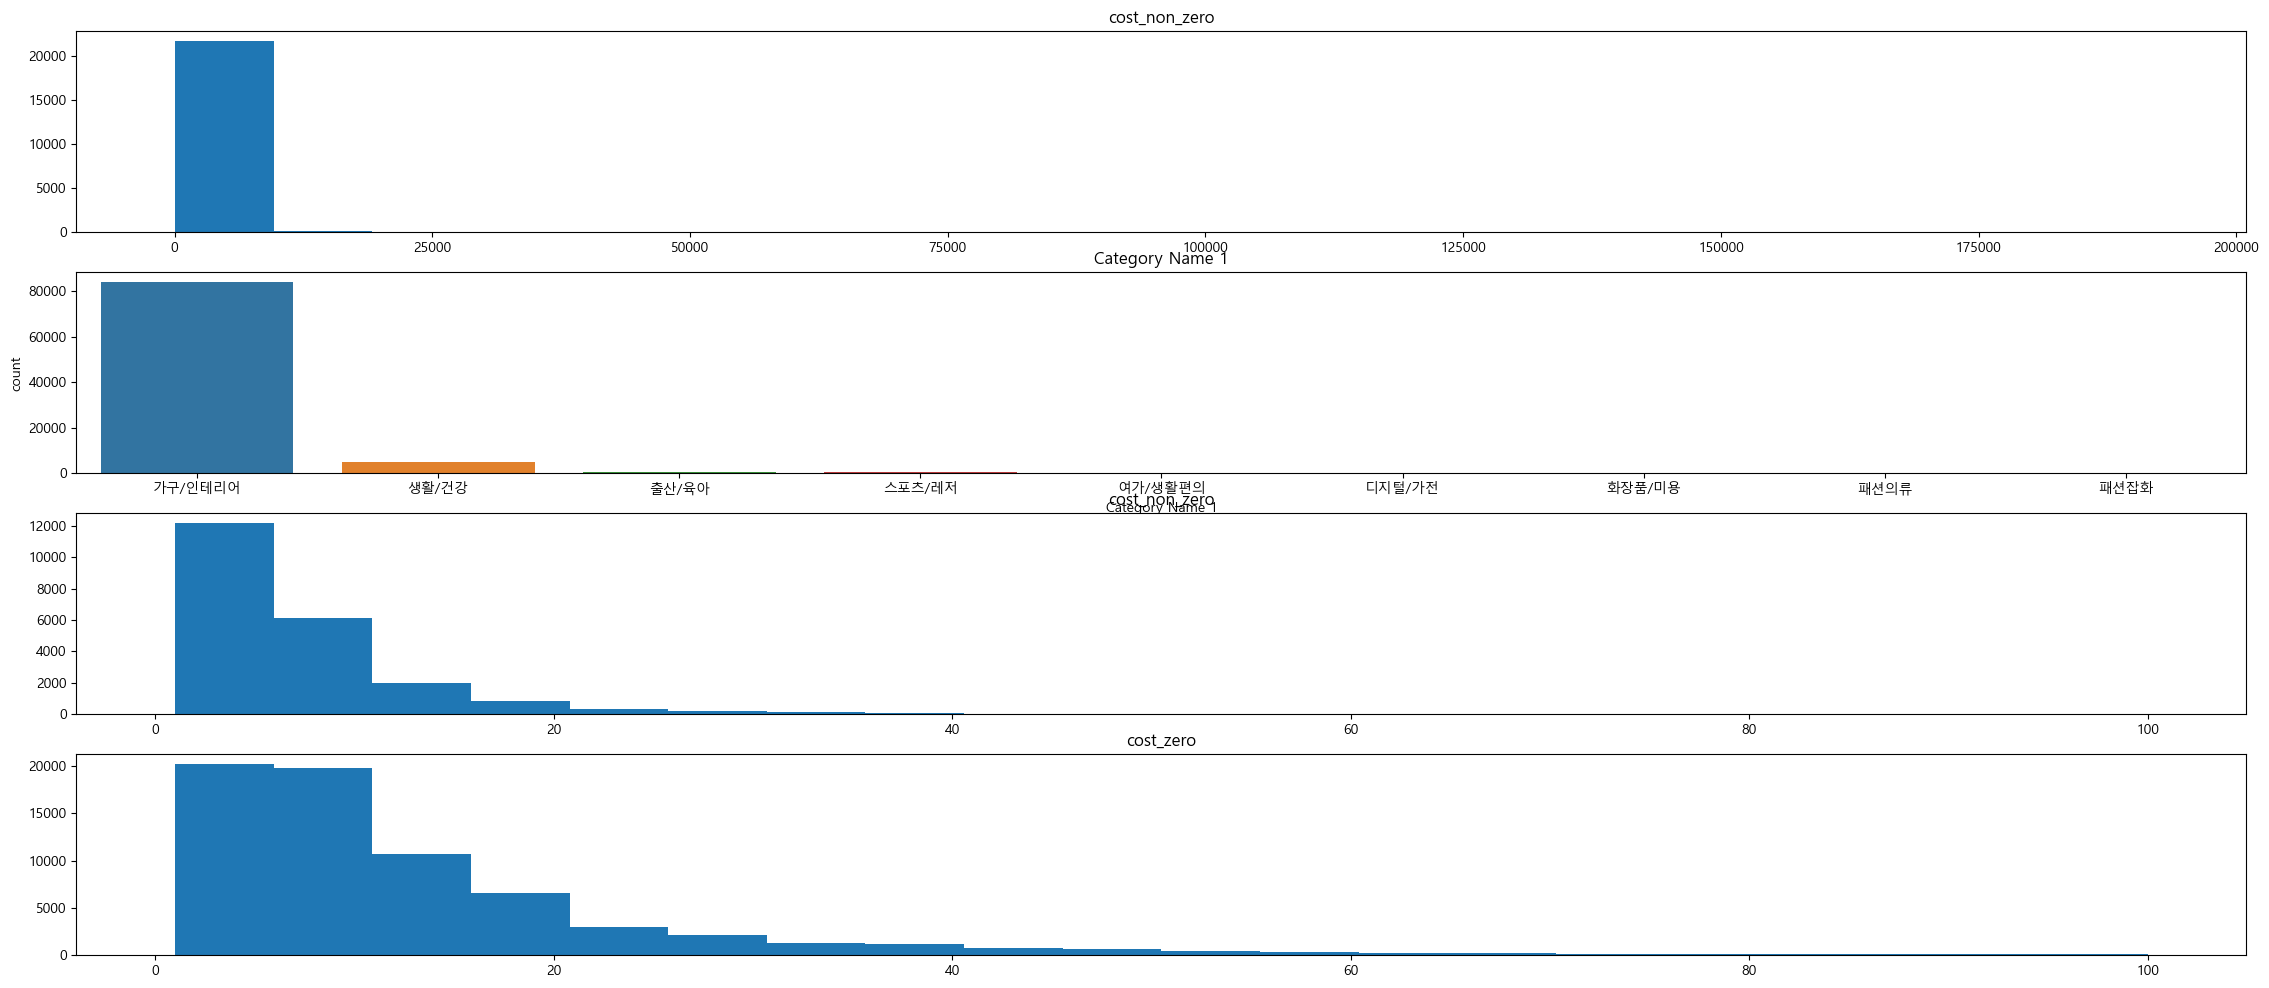

In [18]:
price_Analysis(price_15_20)

비용평균
210.78078991056972
--------------------------------------------------


코스트 썼을때 평균 순위 : 5.927594324616657
코스트 안 썼을때 평균 순위 : 11.778050682443254
--------------------------------------------------


광고숫자비율
3.5259716747169865
--------------------------------------------------


배달비 없음 비율
94.15526299608528


배달비 있음 비율
5.84473700391471
--------------------------------------------------


코스트비율
0.0        0.731555
50.0       0.049074
100.0      0.017521
150.0      0.009432
250.0      0.007051
             ...   
27480.0    0.000003
17020.0    0.000003
14300.0    0.000003
13070.0    0.000003
15800.0    0.000003
Name: Cost, Length: 1293, dtype: float64
--------------------------------------------------


코스트


count     78585.000000
mean        785.192976
std        3459.069587
min          50.000000
25%         100.000000
50%         260.000000
75%         600.000000
max      259530.000000
Name: Cost, dtype: float64

--------------------------------------------------


카테고리1


가구/인테리어    0.966342
생활/건강      0.022672
출산/육아      0.005869
스포츠/레저     0.004068
디지털/가전     0.000506
화장품/미용     0.000362
패션잡화       0.000157
여가/생활편의    0.000024
Name: Category Name 1, dtype: float64

--------------------------------------------------


코스트 있음 , 순위


count    78585.000000
mean         5.927594
std          5.286060
min          1.000000
25%          3.000000
50%          5.000000
75%          7.000000
max         90.000000
Name: Sum of AD rank, dtype: float64

--------------------------------------------------


코스트 없음 , 순위


count    214157.000000
mean         11.778051
std          12.014084
min           1.000000
25%           5.000000
50%           8.000000
75%          14.000000
max         100.000000
Name: Sum of AD rank, dtype: float64

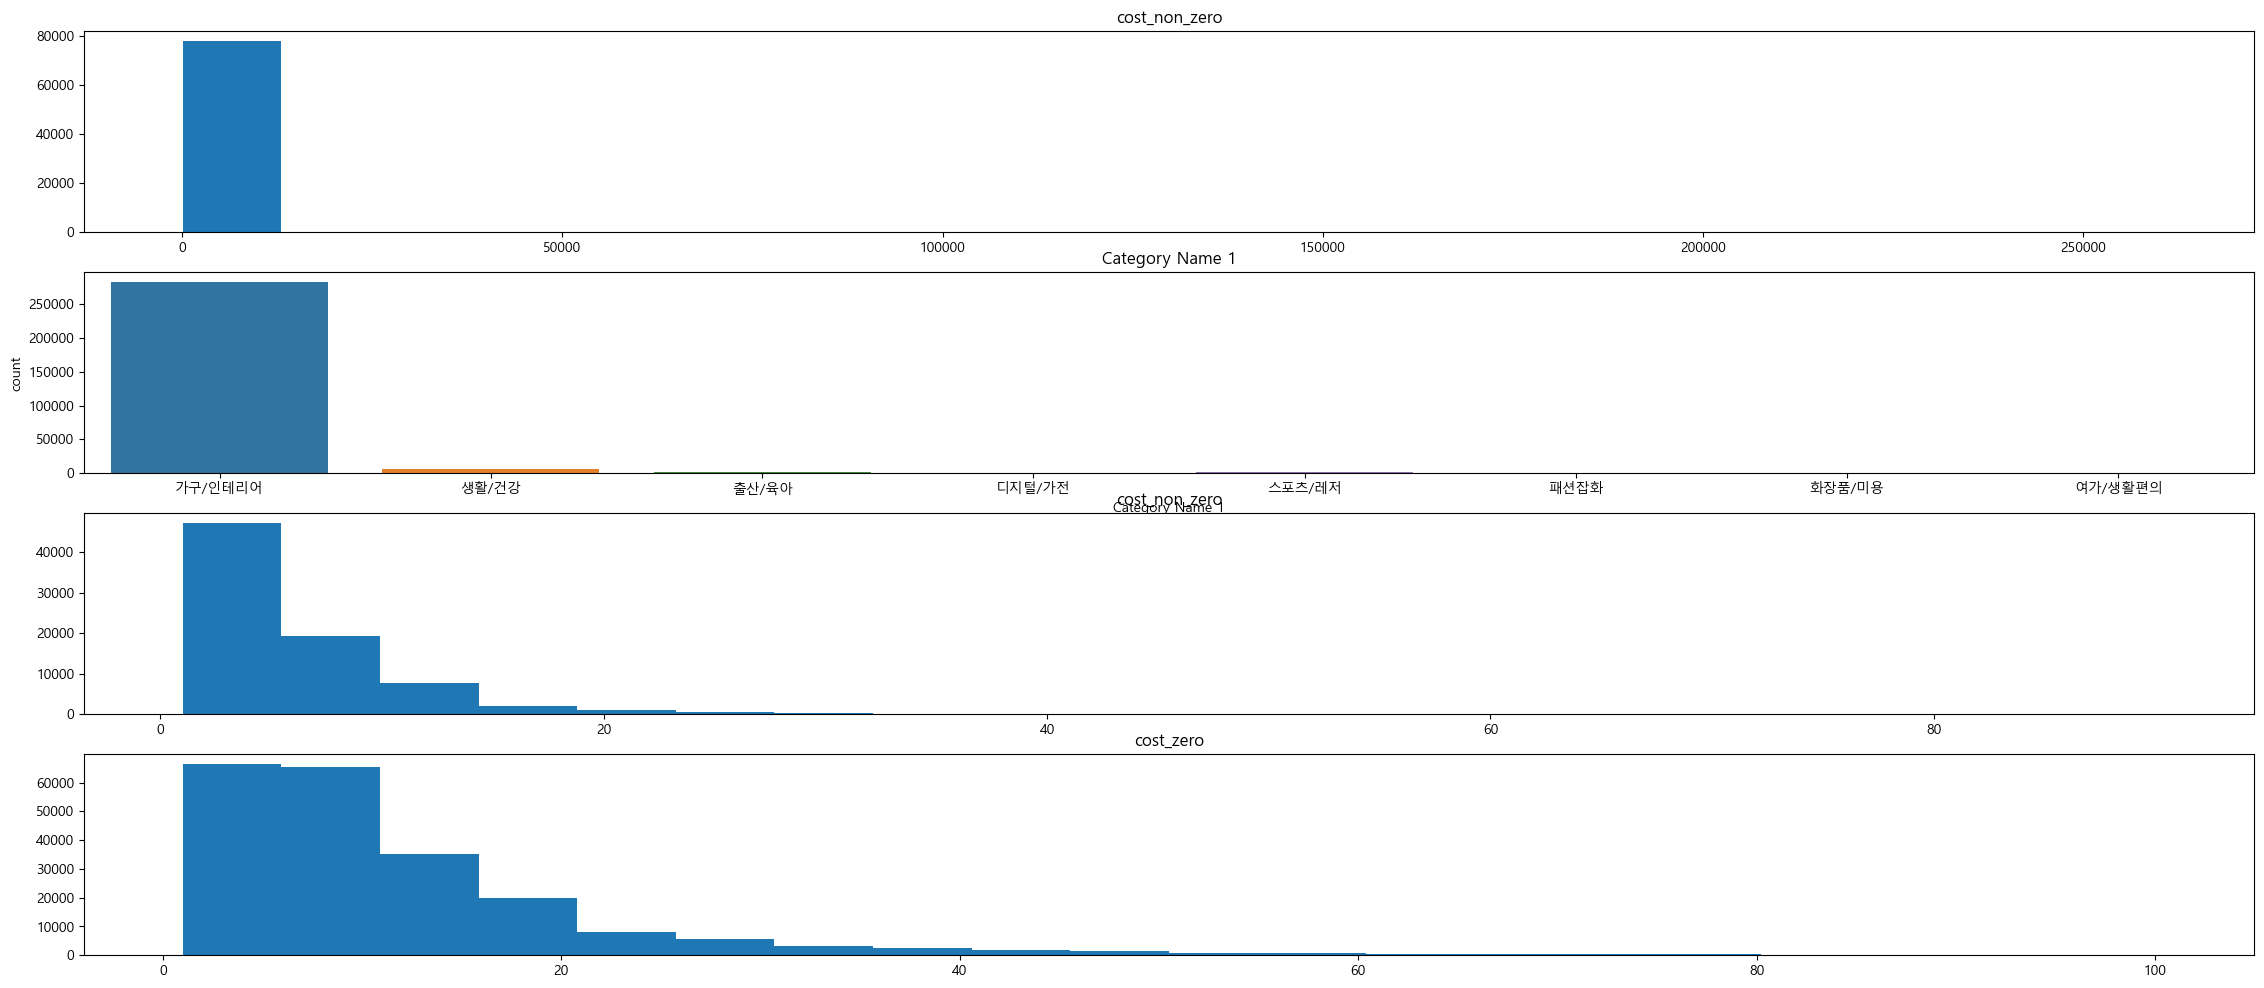

In [19]:
price_Analysis(price_up_20)

In [20]:
def corr_heat(df):
    sns.set(rc = {'figure.figsize':(15,8)}, font_scale = 1)
    sns.heatmap(data = df.corr(), annot=True, linewidths=1)

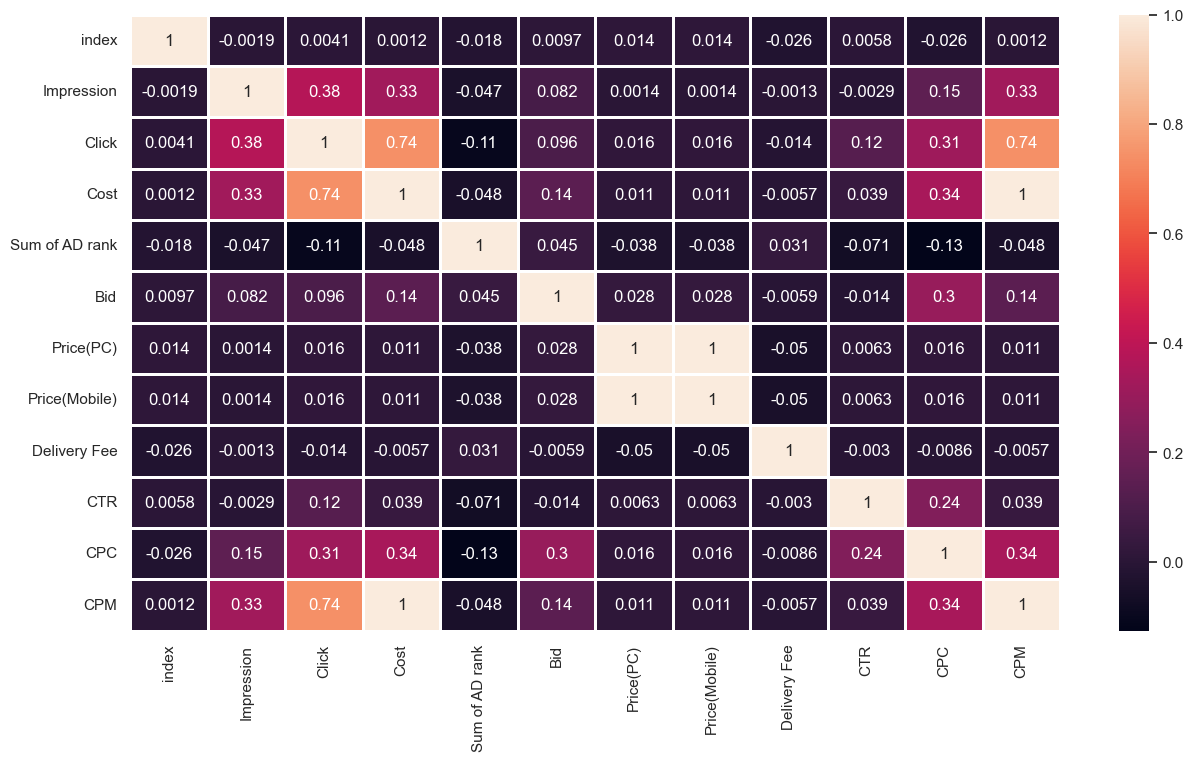

In [21]:
# 그래프 표현
corr_heat(price_down_5)

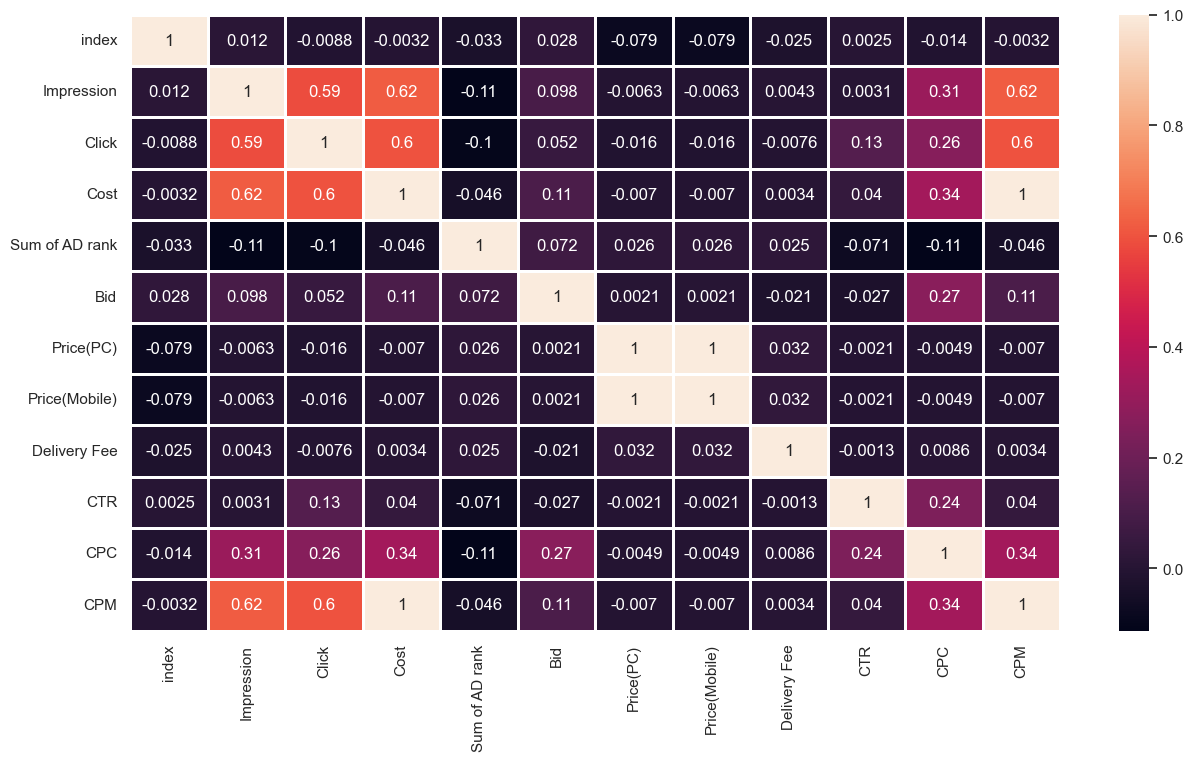

In [22]:
# 그래프 표현
corr_heat(price_5_10)

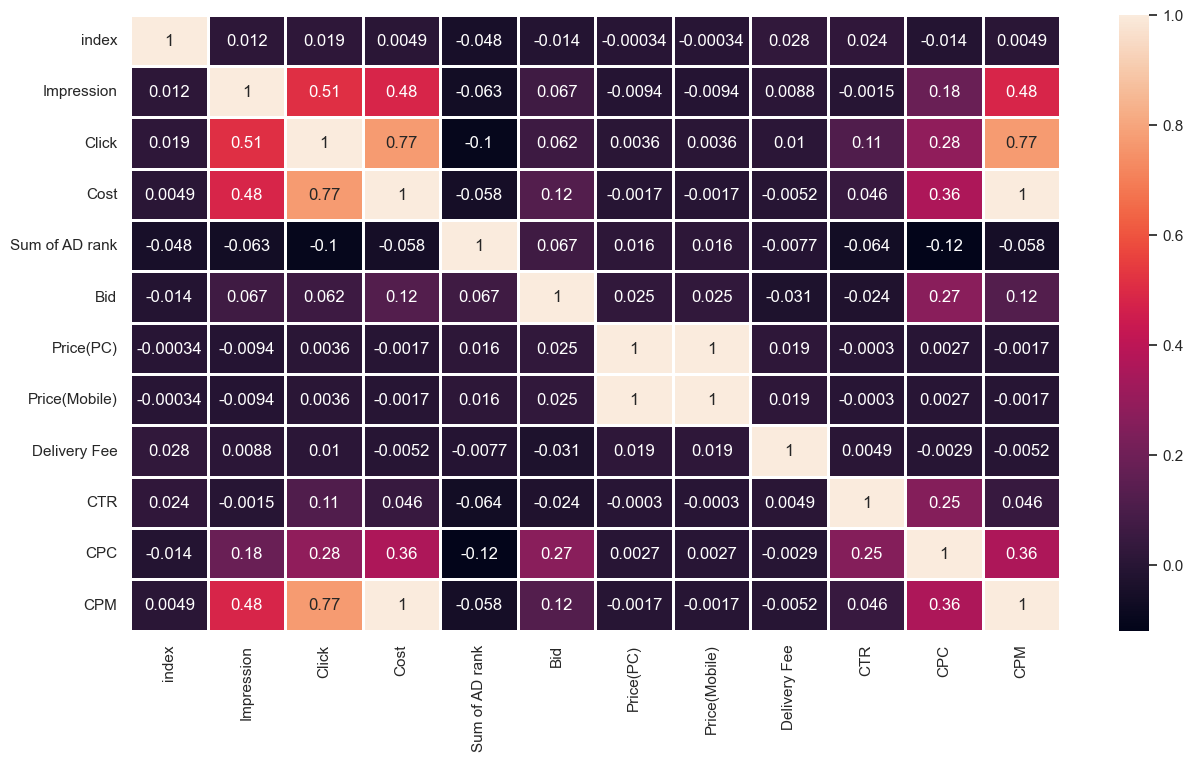

In [23]:
# 그래프 표현
corr_heat(price_10_15)

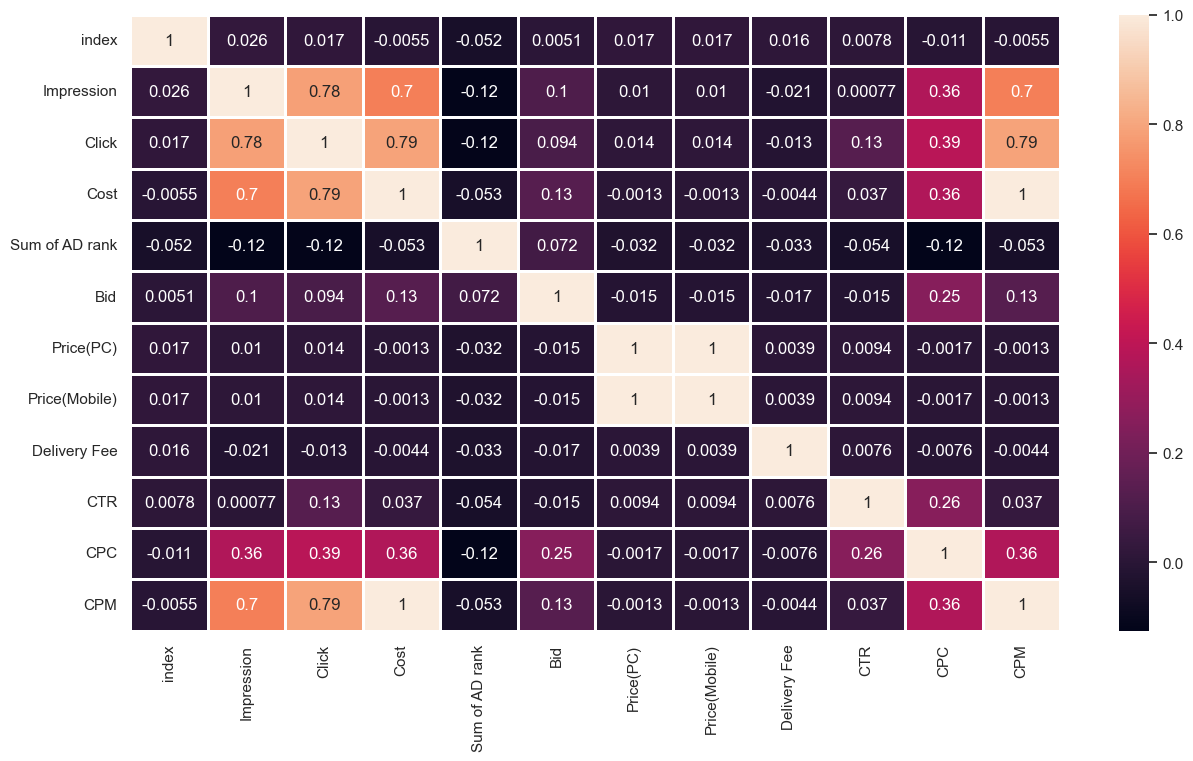

In [24]:
# 그래프 표현
corr_heat(price_15_20)

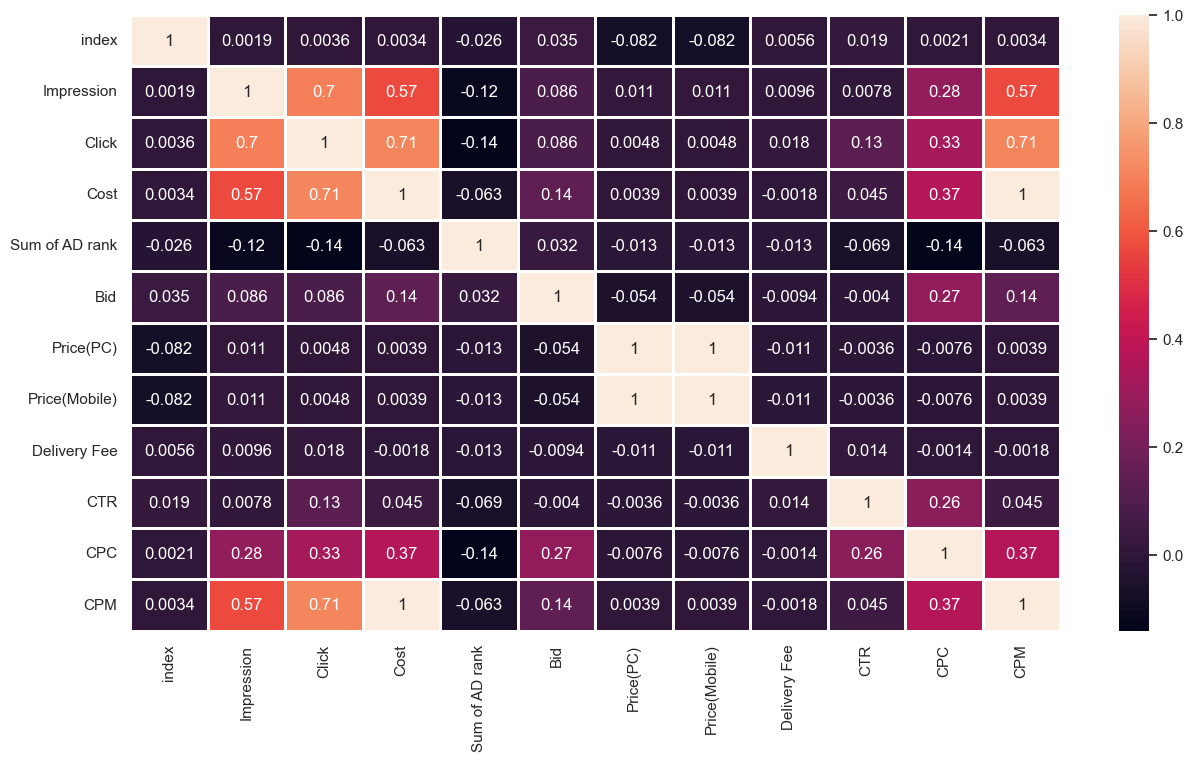

In [25]:
# 그래프 표현
corr_heat(price_up_20)

# Rank 구간별

In [26]:
# 네이버 페이지 기본 default 40, 한페이지에 광고가 6개 상위3개 중간에3개(20개보기, 40개보기, 60개보기, 80개보기)
# log에서 얻은 인사이트로 윈도우가 압도적으로 많으니 윈도우 기준

In [27]:
rank_down_26 = bidding_drop_null[bidding_drop_null['Sum of AD rank'] <= 26]

rank_26_46 = bidding_drop_null[(bidding_drop_null['Sum of AD rank'] > 26) & (bidding_drop_null['Sum of AD rank'] < 46)]

rank_46_66 = bidding_drop_null[(bidding_drop_null['Sum of AD rank'] > 46) & (bidding_drop_null['Sum of AD rank'] < 66)]

rank_66_86 = bidding_drop_null[(bidding_drop_null['Sum of AD rank'] > 66) & (bidding_drop_null['Sum of AD rank'] < 86)]

rank_up_86 = bidding_drop_null[bidding_drop_null['Sum of AD rank'] >= 86]

In [28]:
def rank_col(df):
    print("광고숫자비율")
    print((len(list(set(df['index'].values))) / len(df))*100)
    print('-' * 50)
    
    columns = ['Click', 'Cost', 'Impression', 'Price(PC)']
    
    for col in columns:
        print('\n')
        print(col)
        print(df[col].mean())
        print('-' * 50)
        print(df[col].value_counts(normalize=True))

In [29]:
#수치표현
print("rank_down_26 광고숫자비율")
print((len(list(set(rank_down_26['index'].values))) / len(rank_down_26))*100)
print('-' * 50)
print("rank_26_46 광고숫자비율")
print((len(list(set(rank_26_46['index'].values))) / len(rank_26_46))*100)
print('-' * 50)
print("rank_46_66 광고숫자비율")
print((len(list(set(rank_46_66['index'].values))) / len(rank_46_66))*100)
print('-' * 50)
print("rank_66_86 광고숫자비율")
print((len(list(set(rank_66_86['index'].values))) / len(rank_66_86))*100)
print('-' * 50)
print("rank_up_86 광고숫자비율")
print((len(list(set(rank_up_86['index'].values))) / len(rank_up_86))*100)
print('-' * 50)

rank_down_26 광고숫자비율
3.965566909266703
--------------------------------------------------
rank_26_46 광고숫자비율
25.564515081869292
--------------------------------------------------
rank_46_66 광고숫자비율
39.259515305142685
--------------------------------------------------
rank_66_86 광고숫자비율
49.78980076768415
--------------------------------------------------
rank_up_86 광고숫자비율
56.46306818181818
--------------------------------------------------


In [30]:
#수치표현
print('rank_down_26')
print(rank_down_26['Click'].mean())
print('-' * 50)
print(rank_down_26['Click'].value_counts(normalize=True))
print('-' * 50)
print('rank_26_46')
print(rank_26_46['Click'].mean())
print('-' * 50)
print(rank_26_46['Click'].value_counts(normalize=True))
print('-' * 50)
print('rank_46_66')
print(rank_46_66['Click'].mean())
print('-' * 50)
print(rank_46_66['Click'].value_counts(normalize=True))
print('-' * 50)
print('rank_66_86')
print(rank_66_86['Click'].mean())
print('-' * 50)
print(rank_66_86['Click'].value_counts(normalize=True))
print('-' * 50)
print('rank_up_86')
print(rank_up_86['Click'].mean())
print('-' * 50)
print(rank_up_86['Click'].value_counts(normalize=True))
print('-' * 50)

rank_down_26
0.790540585286385
--------------------------------------------------
0      7.315716e-01
1      1.452935e-01
2      5.034917e-02
3      2.366592e-02
4      1.332921e-02
           ...     
195    8.277981e-07
240    8.277981e-07
257    8.277981e-07
177    8.277981e-07
455    8.277981e-07
Name: Click, Length: 189, dtype: float64
--------------------------------------------------
rank_26_46
0.06485917961902536
--------------------------------------------------
0    0.943139
1    0.050888
2    0.004532
3    0.001039
4    0.000247
5    0.000130
6    0.000026
Name: Click, dtype: float64
--------------------------------------------------
rank_46_66
0.02757614164458271
--------------------------------------------------
0    0.973653
1    0.025195
2    0.001075
3    0.000077
Name: Click, dtype: float64
--------------------------------------------------
rank_66_86
0.009230488027782854
--------------------------------------------------
0    0.99077
1    0.00923
Name: Click, dtype: f

In [31]:
#수치표현
print('rank_down_26')
print(rank_down_26['Cost'].mean())
print('-' * 50)
print(rank_down_26['Cost'].value_counts(normalize=True))
print('-' * 50)
print('rank_26_46')
print(rank_26_46['Cost'].mean())
print('-' * 50)
print(rank_26_46['Cost'].value_counts(normalize=True))
print('-' * 50)
print('rank_46_66')
print(rank_46_66['Cost'].mean())
print('-' * 50)
print(rank_46_66['Cost'].value_counts(normalize=True))
print('-' * 50)
print('rank_66_86')
print(rank_66_86['Cost'].mean())
print('-' * 50)
print(rank_66_86['Cost'].value_counts(normalize=True))
print('-' * 50)
print('rank_up_86')
print(rank_up_86['Cost'].mean())
print('-' * 50)
print(rank_up_86['Cost'].value_counts(normalize=True))
print('-' * 50)

rank_down_26
197.78499433786084
--------------------------------------------------
0.0        7.315716e-01
50.0       5.392856e-02
100.0      1.859731e-02
150.0      9.850798e-03
200.0      7.199360e-03
               ...     
26190.0    8.277981e-07
42270.0    8.277981e-07
10720.0    8.277981e-07
46930.0    8.277981e-07
10160.0    8.277981e-07
Name: Cost, Length: 2406, dtype: float64
--------------------------------------------------
rank_26_46
18.740212691363794
--------------------------------------------------
0.0       0.943139
50.0      0.008414
350.0     0.002987
250.0     0.001883
180.0     0.001766
            ...   
3040.0    0.000013
1470.0    0.000013
2280.0    0.000013
2030.0    0.000013
1890.0    0.000013
Name: Cost, Length: 163, dtype: float64
--------------------------------------------------
rank_46_66
7.31459077466682
--------------------------------------------------
0.0      0.973653
50.0     0.004033
350.0    0.001805
250.0    0.001421
210.0    0.001229
           

In [32]:
#수치표현
print('rank_down_26')
print(rank_down_26['Impression'].mean())
print('-' * 50)
print(rank_down_26['Impression'].value_counts(normalize=True))
print('-' * 50)
print('rank_26_46')
print(rank_26_46['Impression'].mean())
print('-' * 50)
print(rank_26_46['Impression'].value_counts(normalize=True))
print('-' * 50)
print('rank_46_66')
print(rank_46_66['Impression'].mean())
print('-' * 50)
print(rank_46_66['Impression'].value_counts(normalize=True))
print('-' * 50)
print('rank_66_86')
print(rank_66_86['Impression'].mean())
print('-' * 50)
print(rank_66_86['Impression'].value_counts(normalize=True))
print('-' * 50)
print('rank_up_86')
print(rank_up_86['Impression'].mean())
print('-' * 50)
print(rank_up_86['Impression'].value_counts(normalize=True))
print('-' * 50)

rank_down_26
48.3159283259273
--------------------------------------------------
1       9.384416e-02
2       7.156646e-02
3       5.861639e-02
4       4.985414e-02
5       4.313490e-02
            ...     
2211    8.277981e-07
3981    8.277981e-07
2767    8.277981e-07
1163    8.277981e-07
1590    8.277981e-07
Name: Impression, Length: 2732, dtype: float64
--------------------------------------------------
rank_26_46
5.943671847610144
--------------------------------------------------
1      0.214198
2      0.188682
3      0.145261
4      0.095815
5      0.072910
         ...   
120    0.000013
172    0.000013
187    0.000013
236    0.000013
162    0.000013
Name: Impression, Length: 204, dtype: float64
--------------------------------------------------
rank_46_66
3.1726005300149787
--------------------------------------------------
1      0.405615
2      0.245996
3      0.125975
4      0.074778
5      0.044206
         ...   
131    0.000038
98     0.000038
107    0.000038
85     0.000

In [33]:
#수치표현
#mean으로 할지 median으로 할지는 멘토링후 결정 
print('rank_down_26')
print(rank_down_26['Price(PC)'].mean())
print('-' * 50)
print(rank_down_26['Price(PC)'].value_counts(normalize=True))
print('-' * 50)
print('rank_26_46')
print(rank_26_46['Price(PC)'].mean())
print('-' * 50)
print(rank_26_46['Price(PC)'].value_counts(normalize=True))
print('-' * 50)
print('rank_46_66')
print(rank_46_66['Price(PC)'].mean())
print('-' * 50)
print(rank_46_66['Price(PC)'].value_counts(normalize=True))
print('-' * 50)
print('rank_66_86')
print(rank_66_86['Price(PC)'].mean())
print('-' * 50)
print(rank_66_86['Price(PC)'].value_counts(normalize=True))
print('-' * 50)
print('rank_up_86')
print(rank_up_86['Price(PC)'].mean())
print('-' * 50)
print(rank_up_86['Price(PC)'].value_counts(normalize=True))
print('-' * 50)

rank_down_26
187572.42825059767
--------------------------------------------------
9900       1.186069e-02
19900      1.045757e-02
29900      8.902969e-03
12900      8.641385e-03
14900      8.610756e-03
               ...     
1156200    8.277981e-07
1330040    8.277981e-07
1548980    8.277981e-07
1578500    8.277981e-07
2550       8.277981e-07
Name: Price(PC), Length: 7447, dtype: float64
--------------------------------------------------
rank_26_46
143206.4081259008
--------------------------------------------------
9900       0.012037
19900      0.010232
8900       0.009855
7900       0.009037
29900      0.008973
             ...   
1107000    0.000013
3076000    0.000013
47560      0.000013
1376000    0.000013
9000000    0.000013
Name: Price(PC), Length: 3019, dtype: float64
--------------------------------------------------
rank_46_66
136608.30053385565
--------------------------------------------------
19900      0.011599
7900       0.010946
9900       0.010946
4900       0.01063

(array([1]), [Text(0, 0, '')])

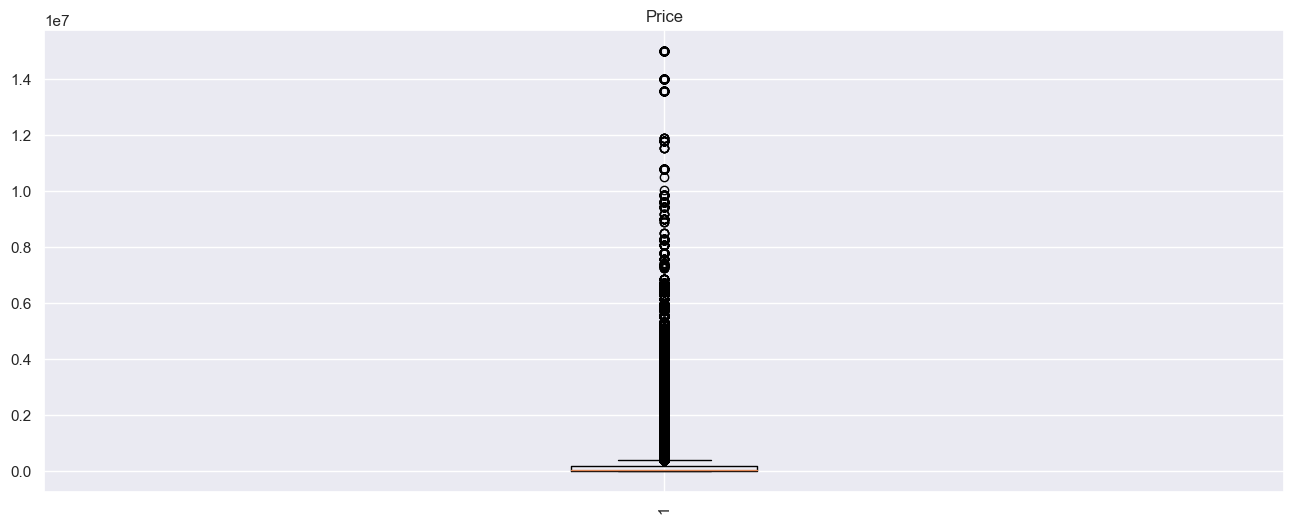

In [34]:
# median으로 한다면 그래프표현
plt.figure(figsize=(16, 6))
plt.boxplot(bidding_drop_null['Price(PC)'])
plt.title('Price')
plt.xticks(rotation=90)

In [35]:
print('rank_down_26')
print(rank_down_26['Price(PC)'].median())
print('-' * 50)
print(rank_down_26['Price(PC)'].value_counts(normalize=True))
print('-' * 50)
print('rank_26_46')
print(rank_26_46['Price(PC)'].median())
print('-' * 50)
print(rank_26_46['Price(PC)'].value_counts(normalize=True))
print('-' * 50)
print('rank_46_66')
print(rank_46_66['Price(PC)'].median())
print('-' * 50)
print(rank_46_66['Price(PC)'].value_counts(normalize=True))
print('-' * 50)
print('rank_66_86')
print(rank_66_86['Price(PC)'].median())
print('-' * 50)
print(rank_66_86['Price(PC)'].value_counts(normalize=True))
print('-' * 50)
print('rank_up_86')
print(rank_up_86['Price(PC)'].median())
print('-' * 50)
print(rank_up_86['Price(PC)'].value_counts(normalize=True))
print('-' * 50)

rank_down_26
59900.0
--------------------------------------------------
9900       1.186069e-02
19900      1.045757e-02
29900      8.902969e-03
12900      8.641385e-03
14900      8.610756e-03
               ...     
1156200    8.277981e-07
1330040    8.277981e-07
1548980    8.277981e-07
1578500    8.277981e-07
2550       8.277981e-07
Name: Price(PC), Length: 7447, dtype: float64
--------------------------------------------------
rank_26_46
45890.0
--------------------------------------------------
9900       0.012037
19900      0.010232
8900       0.009855
7900       0.009037
29900      0.008973
             ...   
1107000    0.000013
3076000    0.000013
47560      0.000013
1376000    0.000013
9000000    0.000013
Name: Price(PC), Length: 3019, dtype: float64
--------------------------------------------------
rank_46_66
39500.0
--------------------------------------------------
19900      0.011599
7900       0.010946
9900       0.010946
4900       0.010639
8900       0.010331
          

## Rank 26이하와 26초과로 분석

In [36]:
rank_down_26 = bidding_drop_null[bidding_drop_null['Sum of AD rank'] <= 26]
rank_up_26 = bidding_drop_null[bidding_drop_null['Sum of AD rank'] > 26]

In [37]:
def rank_Analysis(df):
        
    print('비용평균')
    print(df['Cost'].mean())
    print('-' * 50)
    print('\n')
    
    cost_non_zero = df[df['Cost'] != 0]
    
    
    print(f'코스트 썼을때 평균 순위 : {cost_non_zero["Sum of AD rank"].mean()}')

    cost_zero = df[df['Cost'] == 0]

    print(f'코스트 안 썼을때 평균 순위 : {cost_zero["Sum of AD rank"].mean()}')
    print('-' * 50)
    print('\n')
  

    print("광고숫자비율")
    print((len(list(set(df['index'].values))) / len(df))*100)
    print('-' * 50)
    print('\n')
    
    
    rank_del_zero = df[df['Delivery Fee'] <= 0]
    rank_del_non_zero = df[df['Delivery Fee'] > 0]
    print('배달비 없음 비율')
    print((rank_del_zero.shape[0] / df['Delivery Fee'].shape[0]*100))
    print('\n')
    print('배달비 있음 비율')
    print((rank_del_non_zero.shape[0] / df['Delivery Fee'].shape[0]*100))  
    print('-' * 50)
    print('\n')
    
    print('상품가격 중간값')
    print(f'{df["Price(PC)"].median()} 원')
    print('-' * 50)
    print('\n')
    
    plt.figure(figsize=(28, 12))
    print('카테고리1')
    display(df['Category Name 1'].value_counts(normalize=True))
    sns.countplot(x=df['Category Name 1'], data=df)
    plt.title('Category Name 1')
    plt.xticks(rotation=90)
    

비용평균
197.78499433786084
--------------------------------------------------


코스트 썼을때 평균 순위 : 5.679798808393057
코스트 안 썼을때 평균 순위 : 8.780434871163534
--------------------------------------------------


광고숫자비율
3.965566909266703
--------------------------------------------------


배달비 없음 비율
65.05789620073773


배달비 있음 비율
34.94210379926226
--------------------------------------------------


상품가격 중간값
59900.0 원
--------------------------------------------------


카테고리1


가구/인테리어    0.715840
생활/건강      0.233250
출산/육아      0.020022
스포츠/레저     0.011914
화장품/미용     0.006022
패션잡화       0.005748
디지털/가전     0.004581
패션의류       0.001797
여가/생활편의    0.000659
식품         0.000166
Name: Category Name 1, dtype: float64

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 44032 (\N{HANGUL SYLLABLE GA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 44396 (\N{HANGUL SYLLABLE GU}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 51064 (\N{HANGUL SYLLABLE IN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 53580 (\N{HANGUL SYLLABLE TE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 47532 (\N{HANGUL SYLLABLE RI}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\ProgramData\Anaconda3\lib\s

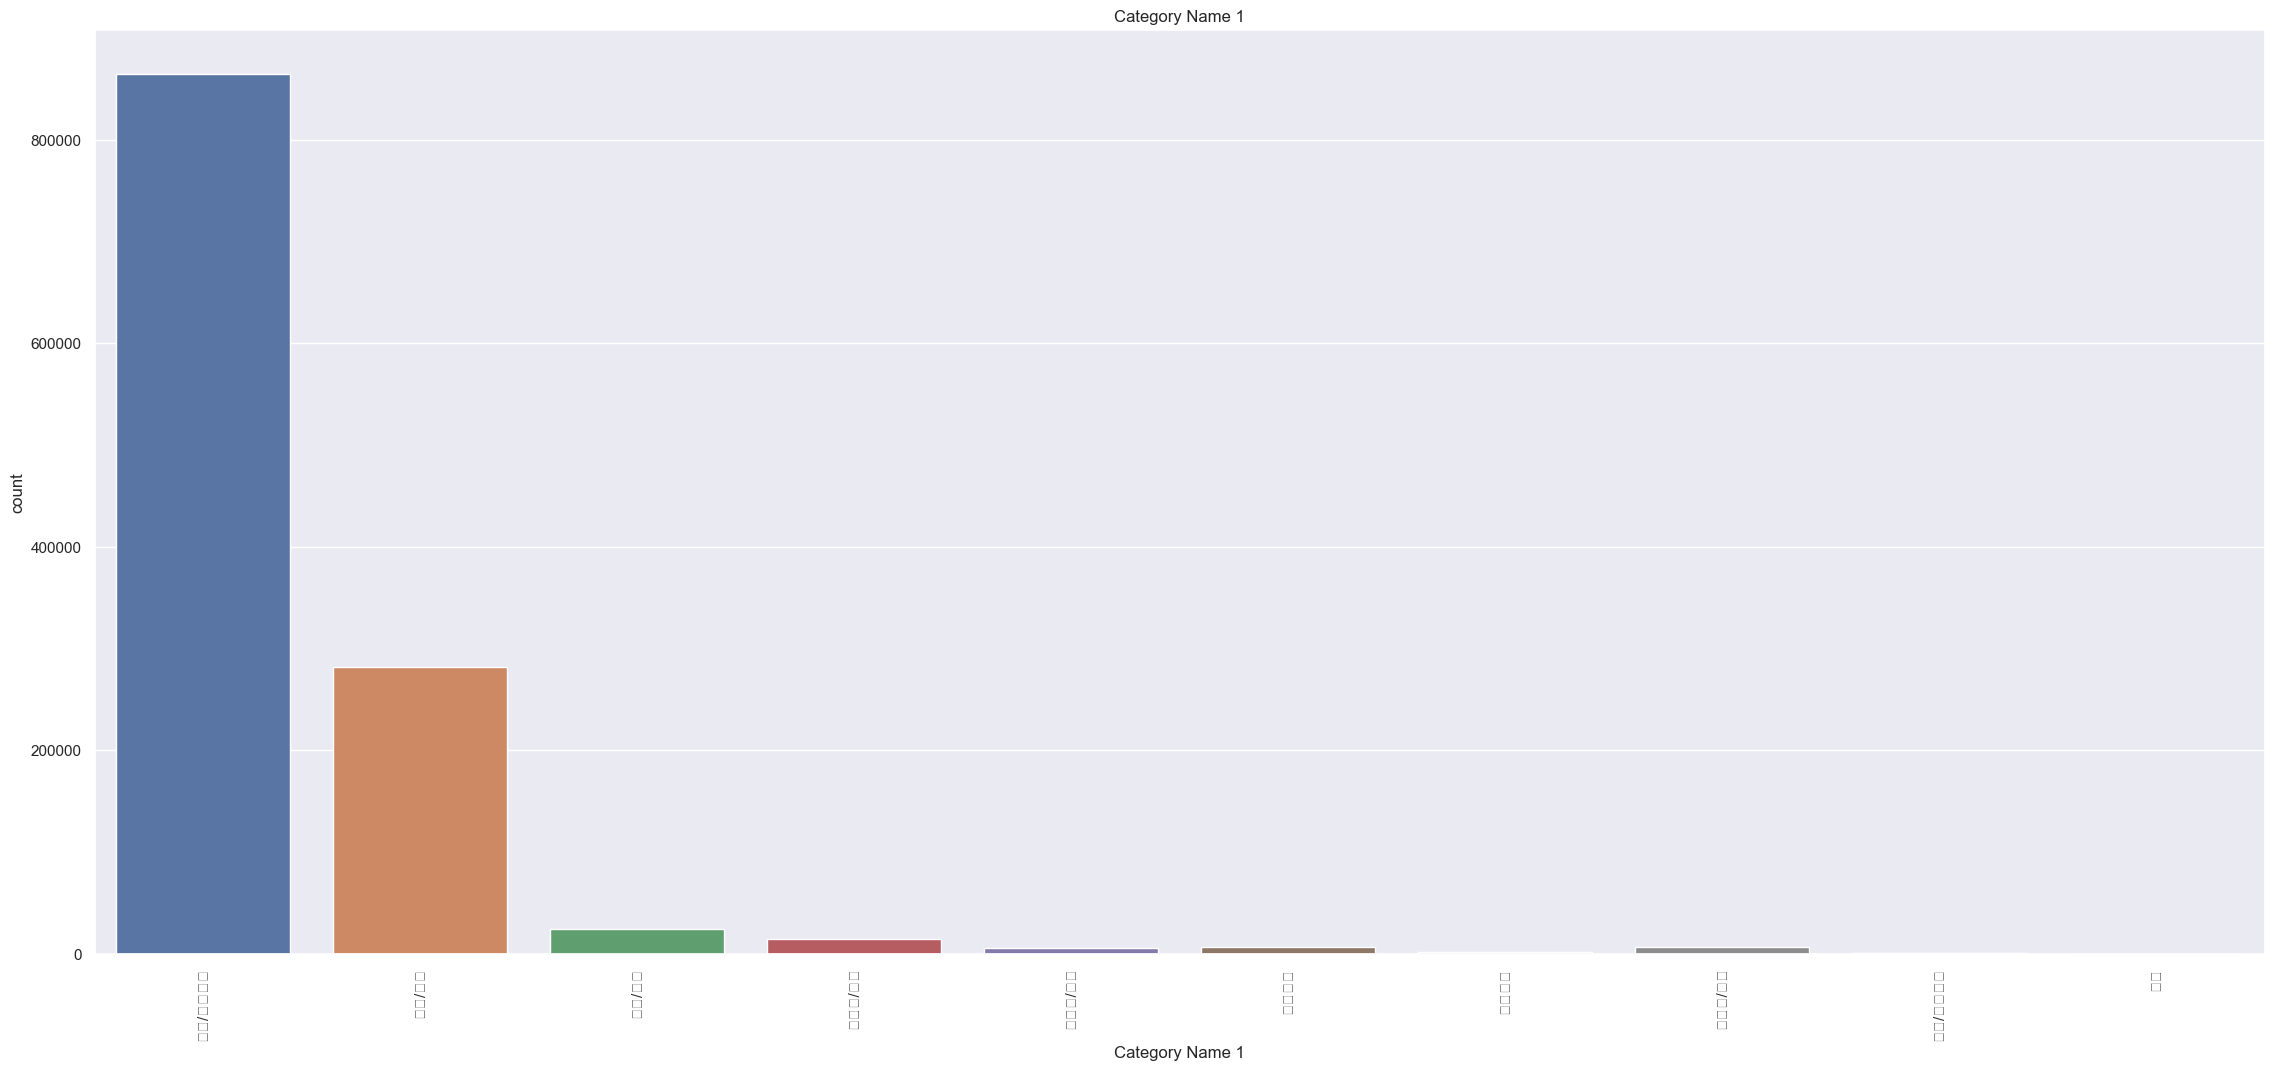

In [38]:
#수치표현
#그래프표현
rank_Analysis(rank_down_26)

비용평균
13.74812277269517
--------------------------------------------------


코스트 썼을때 평균 순위 : 36.91611687087653
코스트 안 썼을때 평균 순위 : 45.574235252201355
--------------------------------------------------


광고숫자비율
18.159383701202238
--------------------------------------------------


배달비 없음 비율
58.151428316299615


배달비 있음 비율
41.84857168370039
--------------------------------------------------


상품가격 중간값
42800.0 원
--------------------------------------------------


카테고리1


가구/인테리어    0.723656
생활/건강      0.245456
스포츠/레저     0.012850
패션잡화       0.006851
출산/육아      0.006251
디지털/가전     0.001624
화장품/미용     0.001591
패션의류       0.001299
여가/생활편의    0.000341
식품         0.000081
Name: Category Name 1, dtype: float64

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 44032 (\N{HANGUL SYLLABLE GA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 44396 (\N{HANGUL SYLLABLE GU}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 51064 (\N{HANGUL SYLLABLE IN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 53580 (\N{HANGUL SYLLABLE TE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 47532 (\N{HANGUL SYLLABLE RI}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\ProgramData\Anaconda3\lib\s

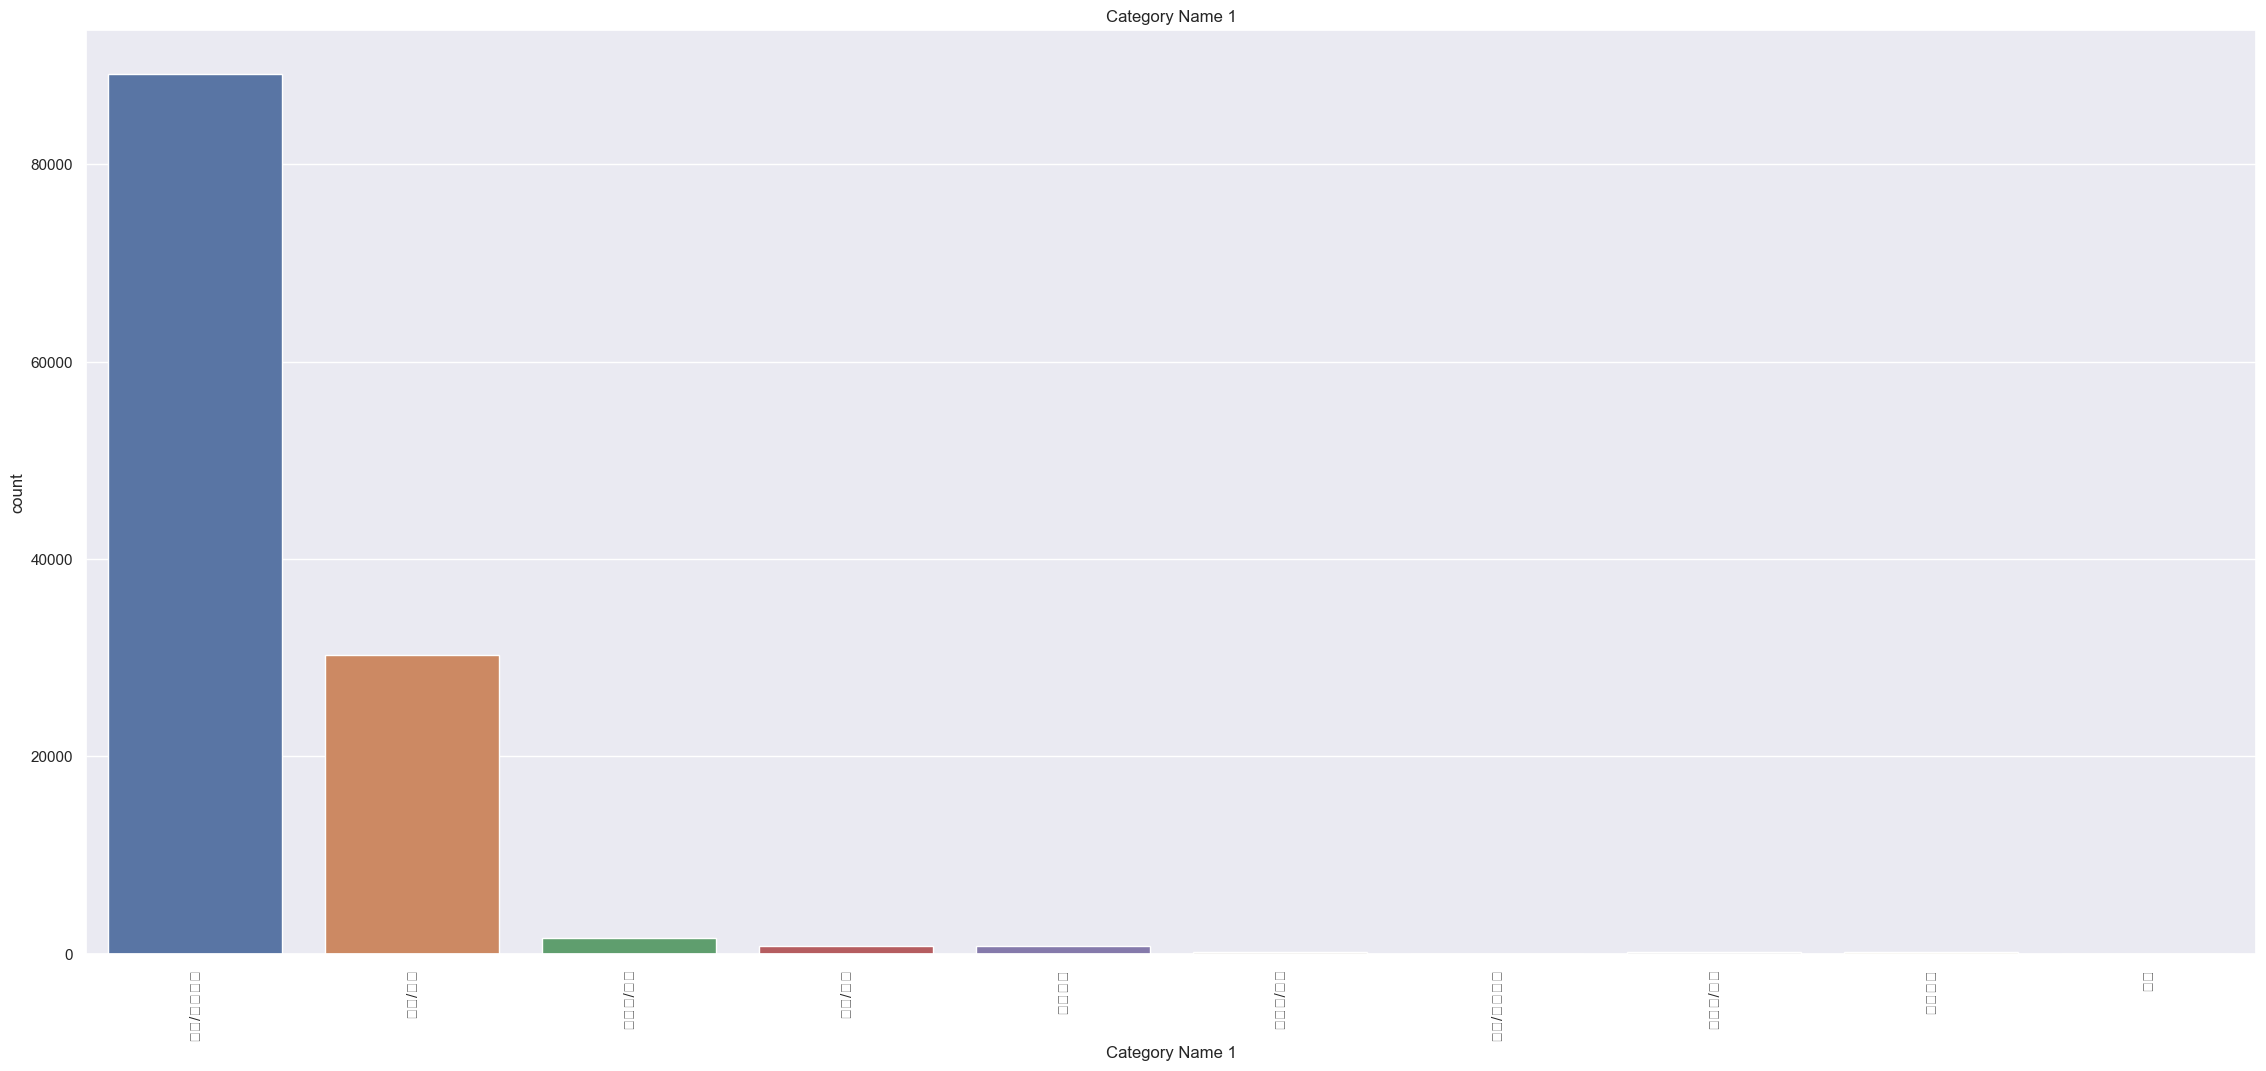

In [39]:
#수치표현
#그래프표현
rank_Analysis(rank_up_26)

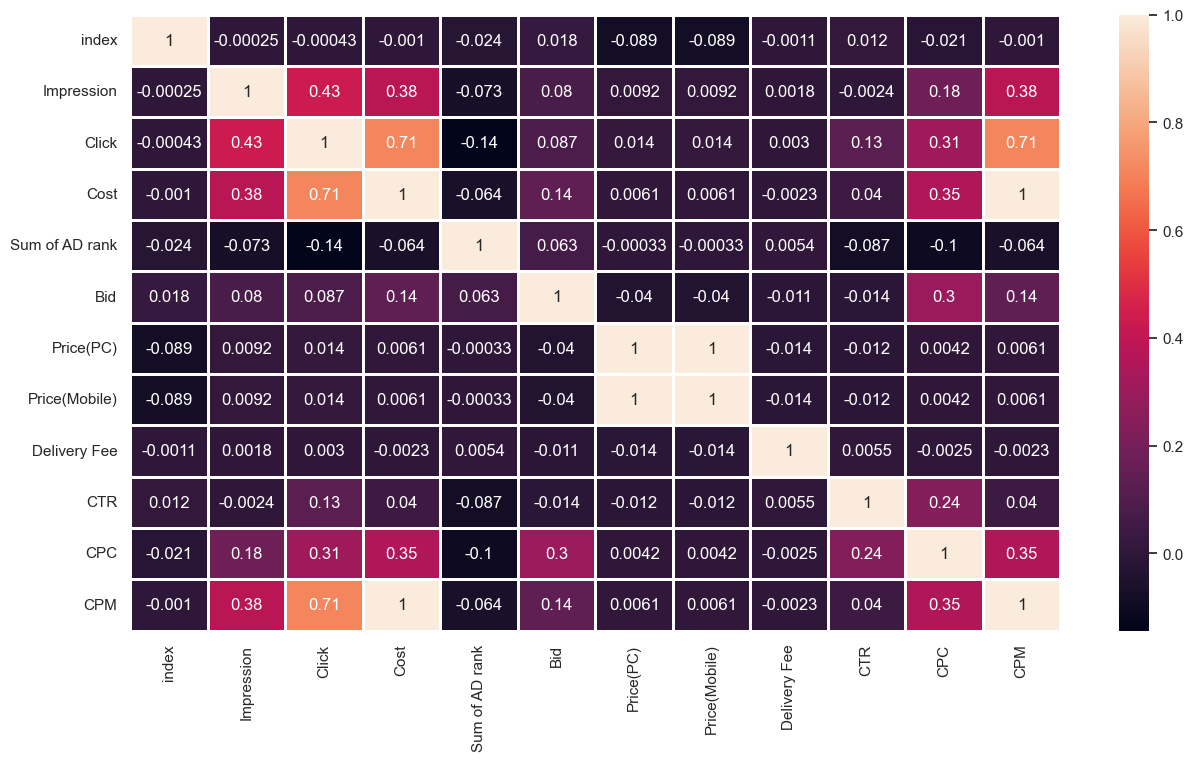

In [40]:
#그래프표현
corr_heat(rank_down_26)

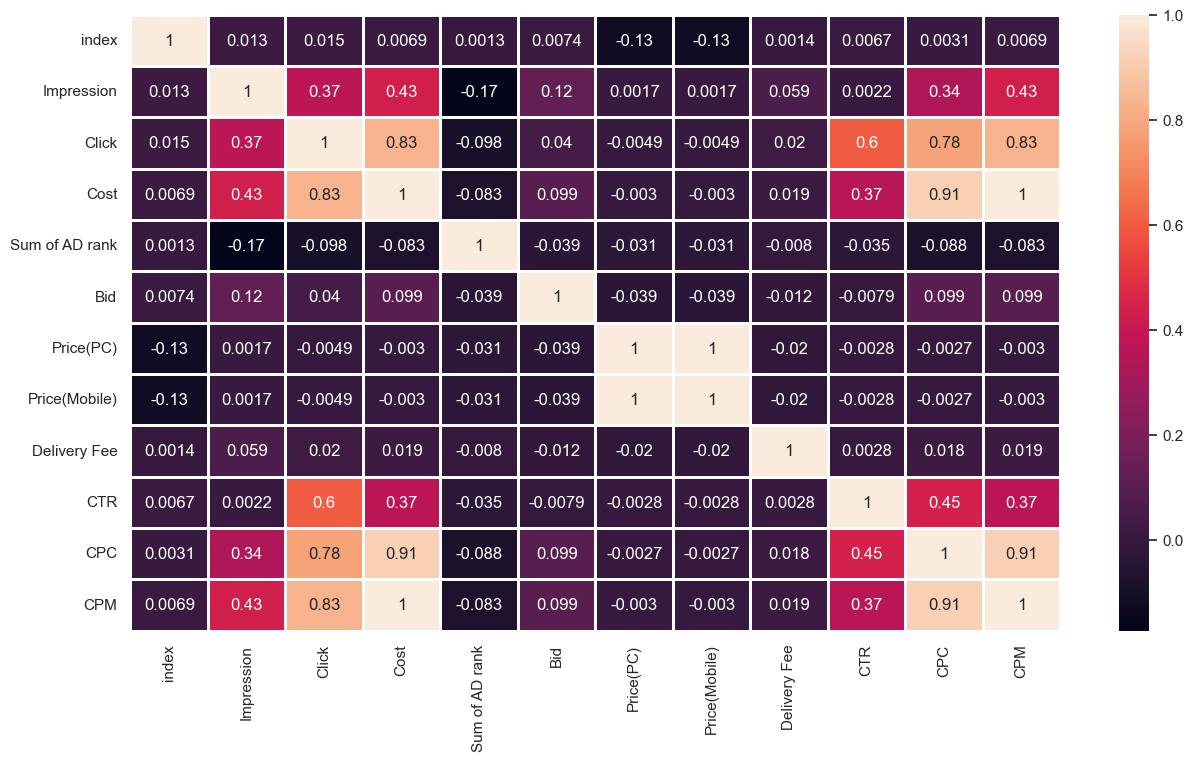

In [41]:
#그래프표현
corr_heat(rank_up_26)

In [42]:
rank_down_7 = bidding_drop_null[bidding_drop_null['Sum of AD rank'] <= 7]

비용평균
295.6721806514001
--------------------------------------------------


코스트 썼을때 평균 순위 : 3.62562659972033
코스트 안 썼을때 평균 순위 : 4.045323442735004
--------------------------------------------------


광고숫자비율
6.262983342236196
--------------------------------------------------


배달비 없음 비율
64.56414332017447


배달비 있음 비율
35.435856679825534
--------------------------------------------------


상품가격 중간값
57000.0 원
--------------------------------------------------


카테고리1


가구/인테리어    0.694310
생활/건강      0.247353
출산/육아      0.024533
스포츠/레저     0.012416
화장품/미용     0.007564
디지털/가전     0.005643
패션잡화       0.005385
패션의류       0.001684
여가/생활편의    0.001003
식품         0.000109
Name: Category Name 1, dtype: float64

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 44032 (\N{HANGUL SYLLABLE GA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 44396 (\N{HANGUL SYLLABLE GU}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 51064 (\N{HANGUL SYLLABLE IN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 53580 (\N{HANGUL SYLLABLE TE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 47532 (\N{HANGUL SYLLABLE RI}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\ProgramData\Anaconda3\lib\s

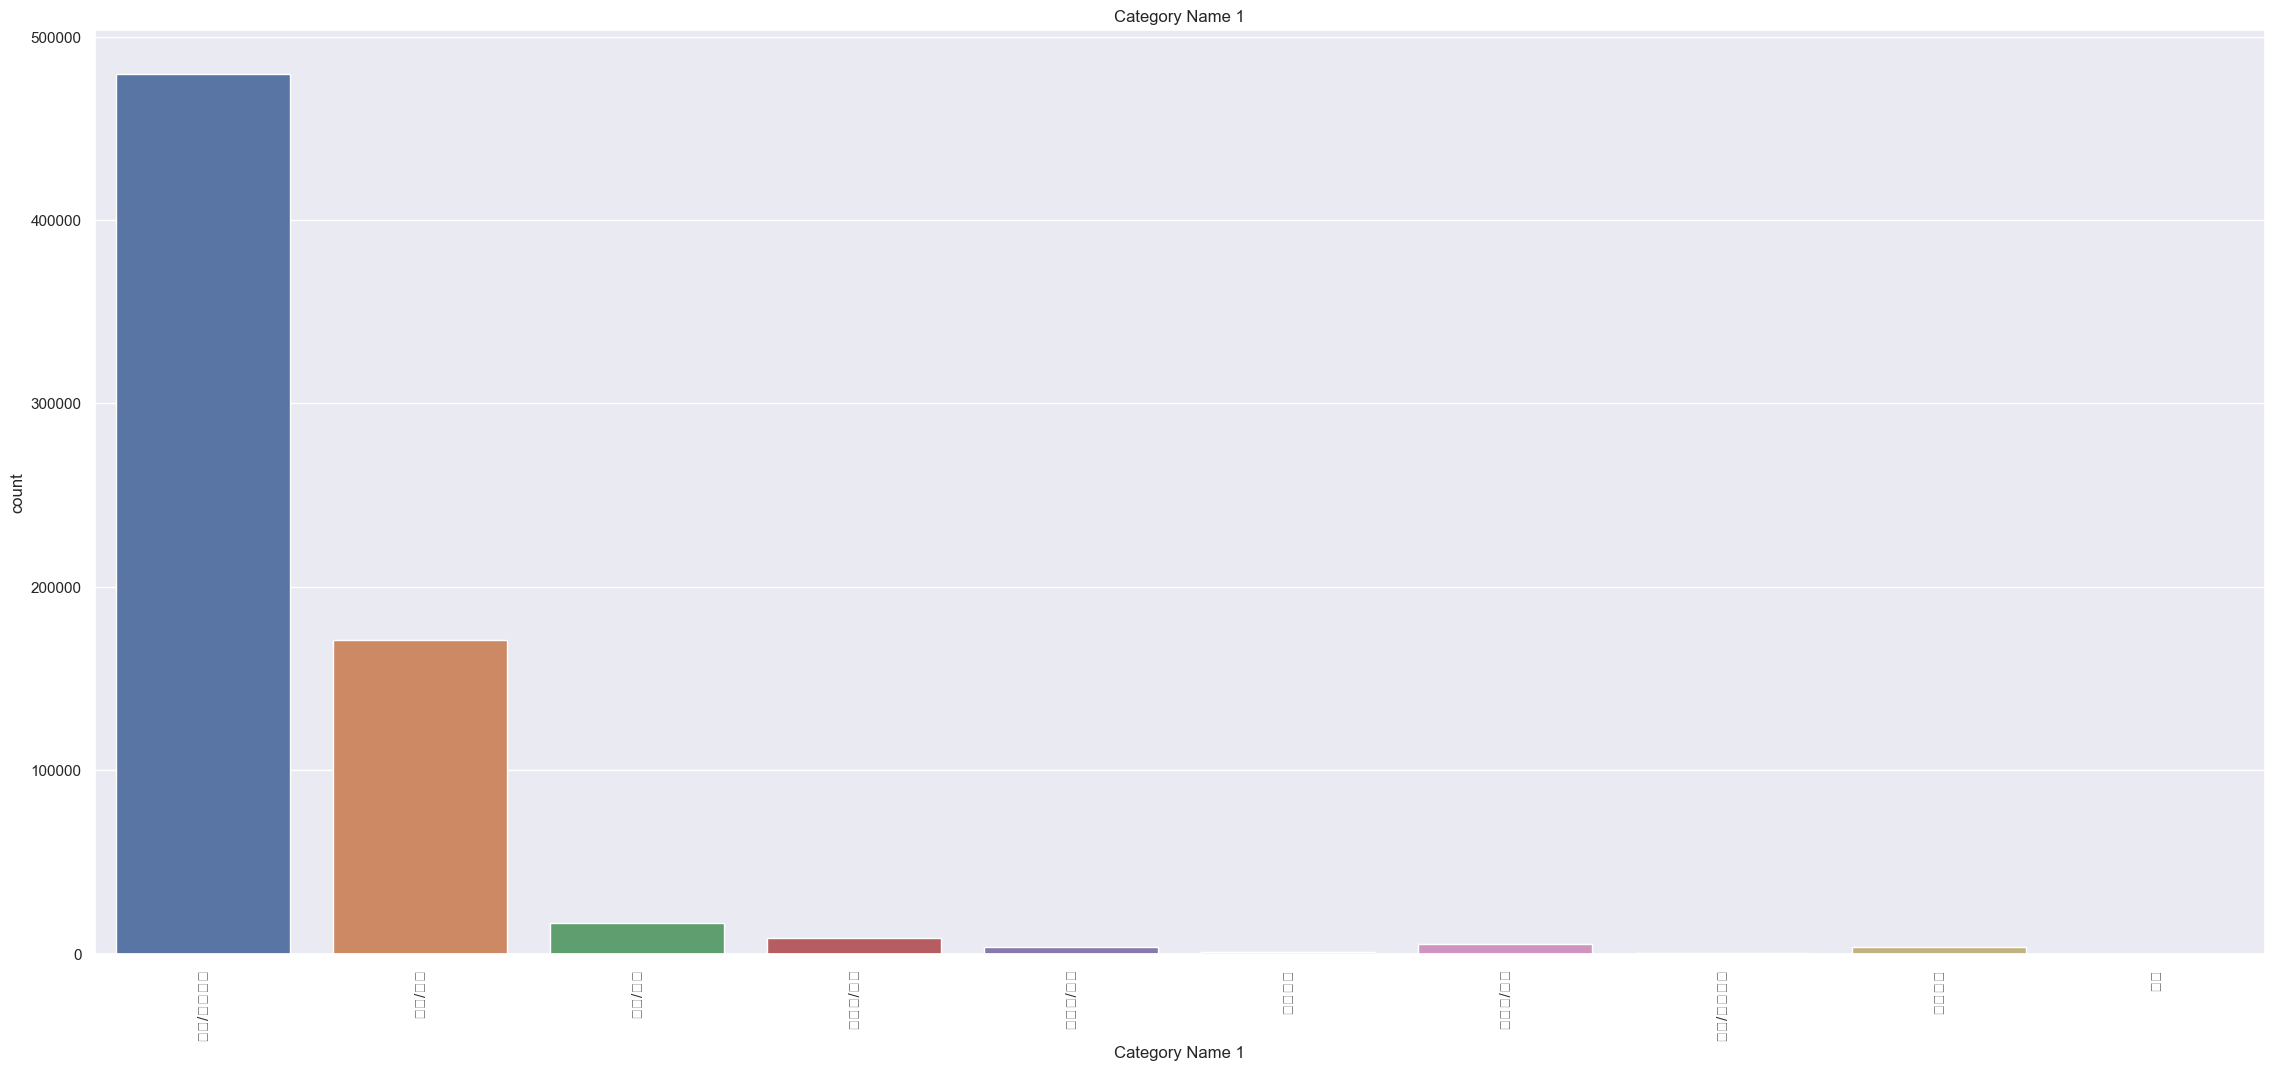

In [43]:
#수치표현
#그래프표현
rank_Analysis(rank_down_7)

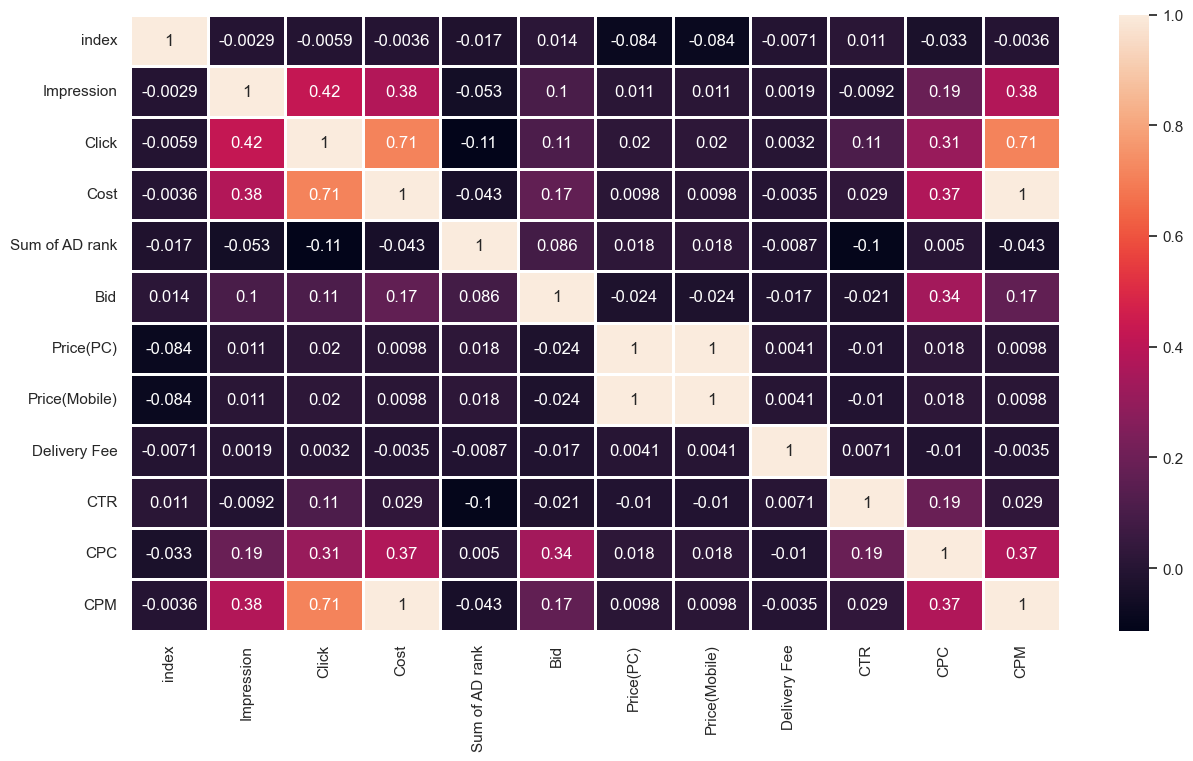

In [44]:
#그래프표현
corr_heat(rank_down_7)

# Category 1별 분석

In [45]:
#수치표현
bidding_drop_null['Category Name 1'].value_counts(normalize=True)

가구/인테리어    0.716563
생활/건강      0.234380
출산/육아      0.018748
스포츠/레저     0.012001
패션잡화       0.005850
화장품/미용     0.005612
디지털/가전     0.004307
패션의류       0.001751
여가/생활편의    0.000630
식품         0.000158
Name: Category Name 1, dtype: float64

In [46]:
cat_val_1 = bidding_drop_null[bidding_drop_null['Category Name 1'].isin(['식품'])]
cat_val_2 = bidding_drop_null[bidding_drop_null['Category Name 1'].isin(['스포츠/레저'])]
cat_val_3 = bidding_drop_null[bidding_drop_null['Category Name 1'].isin(['출산/육아'])]
cat_val_4 = bidding_drop_null[bidding_drop_null['Category Name 1'].isin(['패션의류'])]
cat_val_5 = bidding_drop_null[bidding_drop_null['Category Name 1'].isin(['생활/건강'])]
cat_val_6 = bidding_drop_null[bidding_drop_null['Category Name 1'].isin(['디지털/가전'])]
cat_val_7 = bidding_drop_null[bidding_drop_null['Category Name 1'].isin(['가구/인테리어'])]
cat_val_8 = bidding_drop_null[bidding_drop_null['Category Name 1'].isin(['화장품/미용'])]
cat_val_9 = bidding_drop_null[bidding_drop_null['Category Name 1'].isin(['패션잡화'])]
cat_val_10 = bidding_drop_null[bidding_drop_null['Category Name 1'].isin(['여가/생활편의'])]

In [47]:
def cat_val(df):
    
    print(f'광고비율 : {(len(list(set(df["index"].values))) / len(df))*100}')
    print('-' * 50)
    cat_col = ['Click', 'Cost', 'Sum of AD rank', 'Impression']
    
    for col in cat_col:
        print(f'{col} 평균 : {df[col].mean()}')
        print('-' * 50)
        print(df[col].value_counts(normalize=True))
        print('-' * 50)
        plt.figure(figsize=(16, 6))
        plt.hist(df[col], bins=20)
        plt.title(col)
        plt.xticks(rotation=90)

In [48]:
#수치표현

print((len(list(set(bidding_drop_null['index'].values))) / len(bidding_drop_null))*100)

3.642247547533787


In [49]:
#수치표현
#그래프표현
print("식품 광고숫자비율")
print((len(list(set(cat_val_1['index'].values))) / len(cat_val_1))*100)
print('-' * 50)
print("스포츠/레저 광고숫자비율")
print((len(list(set(cat_val_2['index'].values))) / len(cat_val_2))*100)
print('-' * 50)
print("출산/육아 광고숫자비율")
print((len(list(set(cat_val_3['index'].values))) / len(cat_val_3))*100)
print('-' * 50)
print("패션의류 광고숫자비율")
print((len(list(set(cat_val_4['index'].values))) / len(cat_val_4))*100)
print('-' * 50)
print("생활/건강 광고숫자비율")
print((len(list(set(cat_val_5['index'].values))) / len(cat_val_5))*100)
print('-' * 50)
print("디지털/가전 광고숫자비율")
print((len(list(set(cat_val_6['index'].values))) / len(cat_val_6))*100)
print('-' * 50)
print("가구/인테리어 광고숫자비율")
print((len(list(set(cat_val_7['index'].values))) / len(cat_val_7))*100)
print('-' * 50)
print("화장품/미용 광고숫자비율")
print((len(list(set(cat_val_8['index'].values))) / len(cat_val_8))*100)
print('-' * 50)
print("패션잡화 광고숫자비율")
print((len(list(set(cat_val_9['index'].values))) / len(cat_val_9))*100)
print('-' * 50)
print("여가/생활편의 광고숫자비율")
print((len(list(set(cat_val_10['index'].values))) / len(cat_val_10))*100)
print('-' * 50)

식품 광고숫자비율
3.8095238095238098
--------------------------------------------------
스포츠/레저 광고숫자비율
3.5302954431647473
--------------------------------------------------
출산/육아 광고숫자비율
3.73041631606363
--------------------------------------------------
패션의류 광고숫자비율
5.105105105105105
--------------------------------------------------
생활/건강 광고숫자비율
3.749891830043364
--------------------------------------------------
디지털/가전 광고숫자비율
3.2089291942797344
--------------------------------------------------
가구/인테리어 광고숫자비율
3.608356038440209
--------------------------------------------------
화장품/미용 광고숫자비율
4.028911792263418
--------------------------------------------------
패션잡화 광고숫자비율
3.4797123780174624
--------------------------------------------------
여가/생활편의 광고숫자비율
3.221957040572793
--------------------------------------------------


In [50]:
#수치표현

bidding_drop_null['Click'].mean()

0.7218645278622247

In [51]:
#수치표현
#그래프표현
print('식품')
print(cat_val_1['Click'].mean())
print('-' * 50)
print(cat_val_1['Click'].value_counts(normalize=True))
print('-' * 50)
print('스포츠/레저')
print(cat_val_2['Click'].mean())
print('-' * 50)
print(cat_val_2['Click'].value_counts(normalize=True))
print('-' * 50)
print('출산/육아')
print(cat_val_3['Click'].mean())
print('-' * 50)
print(cat_val_3['Click'].value_counts(normalize=True))
print('-' * 50)
print('패션의류')
print(cat_val_4['Click'].mean())
print('-' * 50)
print(cat_val_4['Click'].value_counts(normalize=True))
print('-' * 50)
print('생활/건강')
print(cat_val_5['Click'].mean())
print('-' * 50)
print(cat_val_5['Click'].value_counts(normalize=True))
print('-' * 50)
print('디지털/가전')
print(cat_val_6['Click'].mean())
print('-' * 50)
print(cat_val_6['Click'].value_counts(normalize=True))
print('-' * 50)
print('가구/인테리어')
print(cat_val_7['Click'].mean())
print('-' * 50)
print(cat_val_7['Click'].value_counts(normalize=True))
print('-' * 50)
print('화장품/미용')
print(cat_val_8['Click'].mean())
print('-' * 50)
print(cat_val_8['Click'].value_counts(normalize=True))
print('-' * 50)
print('패션잡화')
print(cat_val_9['Click'].mean())
print('-' * 50)
print(cat_val_9['Click'].value_counts(normalize=True))
print('-' * 50)
print('여가/생활편의/건강')
print(cat_val_10['Click'].mean())
print('-' * 50)
print(cat_val_10['Click'].value_counts(normalize=True))
print('-' * 50)

식품
0.11428571428571428
--------------------------------------------------
0    0.895238
1    0.100000
3    0.004762
Name: Click, dtype: float64
--------------------------------------------------
스포츠/레저
1.2496244366549825
--------------------------------------------------
0      0.670255
1      0.158112
2      0.064847
3      0.034051
4      0.021282
         ...   
150    0.000063
61     0.000063
45     0.000063
58     0.000063
59     0.000063
Name: Click, Length: 75, dtype: float64
--------------------------------------------------
출산/육아
2.120126617782586
--------------------------------------------------
0      0.578876
1      0.170253
2      0.078936
3      0.039989
4      0.026606
         ...   
144    0.000040
68     0.000040
94     0.000040
73     0.000040
71     0.000040
Name: Click, Length: 94, dtype: float64
--------------------------------------------------
패션의류
1.0574860574860574
--------------------------------------------------
0     0.734878
1     0.139425
2     0.043758

In [52]:
#수치표현

bidding_drop_null['Cost'].mean()

180.75467375194467

In [53]:
#수치표현

print('식품')
print(cat_val_1['Cost'].mean())
print('-' * 50)
print(cat_val_1['Cost'].value_counts(normalize=True))
print('-' * 50)
print('스포츠/레저')
print(cat_val_2['Cost'].mean())
print('-' * 50)
print(cat_val_2['Cost'].value_counts(normalize=True))
print('-' * 50)
print('출산/육아')
print(cat_val_3['Cost'].mean())
print('-' * 50)
print(cat_val_3['Cost'].value_counts(normalize=True))
print('-' * 50)
print('패션의류')
print(cat_val_4['Cost'].mean())
print('-' * 50)
print(cat_val_4['Cost'].value_counts(normalize=True))
print('-' * 50)
print('생활/건강')
print(cat_val_5['Cost'].mean())
print('-' * 50)
print(cat_val_5['Cost'].value_counts(normalize=True))
print('-' * 50)
print('디지털/가전')
print(cat_val_6['Cost'].mean())
print('-' * 50)
print(cat_val_6['Cost'].value_counts(normalize=True))
print('-' * 50)
print('가구/인테리어')
print(cat_val_7['Cost'].mean())
print('-' * 50)
print(cat_val_7['Cost'].value_counts(normalize=True))
print('-' * 50)
print('화장품/미용')
print(cat_val_8['Cost'].mean())
print('-' * 50)
print(cat_val_8['Cost'].value_counts(normalize=True))
print('-' * 50)
print('패션잡화')
print(cat_val_9['Cost'].mean())
print('-' * 50)
print(cat_val_9['Cost'].value_counts(normalize=True))
print('-' * 50)
print('여가/생활편의/건강')
print(cat_val_10['Cost'].mean())
print('-' * 50)
print(cat_val_10['Cost'].value_counts(normalize=True))
print('-' * 50)

식품
9.428571428571429
--------------------------------------------------
0.0      0.895238
50.0     0.076190
210.0    0.009524
150.0    0.004762
180.0    0.004762
100.0    0.004762
330.0    0.004762
Name: Cost, dtype: float64
--------------------------------------------------
스포츠/레저
195.1583625438157
--------------------------------------------------
0.0        0.670255
50.0       0.086755
100.0      0.034301
150.0      0.016838
200.0      0.012644
             ...   
15370.0    0.000063
7520.0     0.000063
5130.0     0.000063
3030.0     0.000063
15800.0    0.000063
Name: Cost, Length: 384, dtype: float64
--------------------------------------------------
출산/육아
293.0640702007453
--------------------------------------------------
0.0        0.578876
50.0       0.106383
100.0      0.049124
150.0      0.026165
200.0      0.018071
             ...   
4510.0     0.000040
5860.0     0.000040
12440.0    0.000040
3220.0     0.000040
2590.0     0.000040
Name: Cost, Length: 538, dtype: float64
--

In [54]:
#수치표현

bidding_drop_null['Sum of AD rank'].mean()

11.395459472615535

In [55]:
#수치표현
#그래프표현
print('식품')
print(cat_val_1['Sum of AD rank'].mean())
print('-' * 50)
print(cat_val_1['Sum of AD rank'].value_counts(normalize=True))
print('-' * 50)
print('스포츠/레저')
print(cat_val_2['Sum of AD rank'].mean())
print('-' * 50)
print(cat_val_2['Sum of AD rank'].value_counts(normalize=True))
print('-' * 50)
print('출산/육아')
print(cat_val_3['Sum of AD rank'].mean())
print('-' * 50)
print(cat_val_3['Sum of AD rank'].value_counts(normalize=True))
print('-' * 50)
print('패션의류')
print(cat_val_4['Sum of AD rank'].mean())
print('-' * 50)
print(cat_val_4['Sum of AD rank'].value_counts(normalize=True))
print('-' * 50)
print('생활/건강')
print(cat_val_5['Sum of AD rank'].mean())
print('-' * 50)
print(cat_val_5['Sum of AD rank'].value_counts(normalize=True))
print('-' * 50)
print('디지털/가전')
print(cat_val_6['Sum of AD rank'].mean())
print('-' * 50)
print(cat_val_6['Sum of AD rank'].value_counts(normalize=True))
print('-' * 50)
print('가구/인테리어')
print(cat_val_7['Sum of AD rank'].mean())
print('-' * 50)
print(cat_val_7['Sum of AD rank'].value_counts(normalize=True))
print('-' * 50)
print('화장품/미용')
print(cat_val_8['Sum of AD rank'].mean())
print('-' * 50)
print(cat_val_8['Sum of AD rank'].value_counts(normalize=True))
print('-' * 50)
print('패션잡화')
print(cat_val_9['Sum of AD rank'].mean())
print('-' * 50)
print(cat_val_9['Sum of AD rank'].value_counts(normalize=True))
print('-' * 50)
print('여가/생활편의/건강')
print(cat_val_10['Sum of AD rank'].mean())
print('-' * 50)
print(cat_val_10['Sum of AD rank'].value_counts(normalize=True))
print('-' * 50)

식품
10.471428571428572
--------------------------------------------------
9.0     0.114286
8.0     0.100000
10.0    0.095238
3.0     0.085714
7.0     0.080952
12.0    0.066667
2.0     0.052381
4.0     0.047619
6.0     0.047619
13.0    0.042857
11.0    0.038095
5.0     0.038095
14.0    0.023810
17.0    0.023810
18.0    0.014286
26.0    0.014286
16.0    0.014286
30.0    0.009524
22.0    0.009524
24.0    0.009524
15.0    0.009524
28.0    0.009524
20.0    0.009524
31.0    0.009524
27.0    0.004762
25.0    0.004762
1.0     0.004762
23.0    0.004762
29.0    0.004762
54.0    0.004762
73.0    0.004762
Name: Sum of AD rank, dtype: float64
--------------------------------------------------
스포츠/레저
11.489672008012018
--------------------------------------------------
2.0     0.107974
4.0     0.084627
3.0     0.080809
5.0     0.071795
6.0     0.069604
          ...   
82.0    0.000188
79.0    0.000188
88.0    0.000125
81.0    0.000125
85.0    0.000125
Name: Sum of AD rank, Length: 100, dtype: float6

In [56]:
#수치표현

bidding_drop_null['Impression'].mean()

44.281237159248235

In [57]:
#수치표현
#그래프표현
print('식품')
print(cat_val_1['Impression'].mean())
print('-' * 50)
print(cat_val_1['Impression'].value_counts(normalize=True))
print('-' * 50)
print('스포츠/레저')
print(cat_val_2['Impression'].mean())
print('-' * 50)
print(cat_val_2['Impression'].value_counts(normalize=True))
print('-' * 50)
print('출산/육아')
print(cat_val_3['Impression'].mean())
print('-' * 50)
print(cat_val_3['Impression'].value_counts(normalize=True))
print('-' * 50)
print('패션의류')
print(cat_val_4['Impression'].mean())
print('-' * 50)
print(cat_val_4['Impression'].value_counts(normalize=True))
print('-' * 50)
print('생활/건강')
print(cat_val_5['Impression'].mean())
print('-' * 50)
print(cat_val_5['Impression'].value_counts(normalize=True))
print('-' * 50)
print('디지털/가전')
print(cat_val_6['Impression'].mean())
print('-' * 50)
print(cat_val_6['Impression'].value_counts(normalize=True))
print('-' * 50)
print('가구/인테리어')
print(cat_val_7['Impression'].mean())
print('-' * 50)
print(cat_val_7['Impression'].value_counts(normalize=True))
print('-' * 50)
print('화장품/미용')
print(cat_val_8['Impression'].mean())
print('-' * 50)
print(cat_val_8['Impression'].value_counts(normalize=True))
print('-' * 50)
print('패션잡화')
print(cat_val_9['Impression'].mean())
print('-' * 50)
print(cat_val_9['Impression'].value_counts(normalize=True))
print('-' * 50)
print('여가/생활편의/건강')
print(cat_val_10['Impression'].mean())
print('-' * 50)
print(cat_val_10['Impression'].value_counts(normalize=True))
print('-' * 50)

식품
28.714285714285715
--------------------------------------------------
1      0.109524
3      0.076190
4      0.066667
2      0.061905
5      0.042857
         ...   
90     0.004762
123    0.004762
86     0.004762
146    0.004762
73     0.004762
Name: Impression, Length: 67, dtype: float64
--------------------------------------------------
스포츠/레저
60.6691912869304
--------------------------------------------------
1       0.082749
2       0.065160
3       0.055270
4       0.045068
5       0.038683
          ...   
347     0.000063
507     0.000063
633     0.000063
328     0.000063
1457    0.000063
Name: Impression, Length: 598, dtype: float64
--------------------------------------------------
출산/육아
76.07284529390552
--------------------------------------------------
1       0.042994
2       0.042353
3       0.032055
5       0.028369
4       0.027607
          ...   
2270    0.000040
602     0.000040
946     0.000040
815     0.000040
864     0.000040
Name: Impression, Length: 835, dty

In [58]:
#수치표현

bidding_drop_null['Price(PC)'].median()

59000.0

In [59]:
#수치표현
#그래프표현
print('식품')
print(cat_val_1['Price(PC)'].median())
print('-' * 50)
print(cat_val_1['Price(PC)'].value_counts(normalize=True))
print('-' * 50)
print('스포츠/레저')
print(cat_val_2['Price(PC)'].median())
print('-' * 50)
print(cat_val_2['Price(PC)'].value_counts(normalize=True))
print('-' * 50)
print('출산/육아')
print(cat_val_3['Price(PC)'].median())
print('-' * 50)
print(cat_val_3['Price(PC)'].value_counts(normalize=True))
print('-' * 50)
print('패션의류')
print(cat_val_4['Price(PC)'].median())
print('-' * 50)
print(cat_val_4['Price(PC)'].value_counts(normalize=True))
print('-' * 50)
print('생활/건강')
print(cat_val_5['Price(PC)'].median())
print('-' * 50)
print(cat_val_5['Price(PC)'].value_counts(normalize=True))
print('-' * 50)
print('디지털/가전')
print(cat_val_6['Price(PC)'].median())
print('-' * 50)
print(cat_val_6['Price(PC)'].value_counts(normalize=True))
print('-' * 50)
print('가구/인테리어')
print(cat_val_7['Price(PC)'].median())
print('-' * 50)
print(cat_val_7['Price(PC)'].value_counts(normalize=True))
print('-' * 50)
print('화장품/미용')
print(cat_val_8['Price(PC)'].median())
print('-' * 50)
print(cat_val_8['Price(PC)'].value_counts(normalize=True))
print('-' * 50)
print('패션잡화')
print(cat_val_9['Price(PC)'].median())
print('-' * 50)
print(cat_val_9['Price(PC)'].value_counts(normalize=True))
print('-' * 50)
print('여가/생활편의/건강')
print(cat_val_10['Price(PC)'].median())
print('-' * 50)
print(cat_val_10['Price(PC)'].value_counts(normalize=True))
print('-' * 50)

식품
10900.0
--------------------------------------------------
5900     0.271429
52000    0.142857
51000    0.114286
9900     0.095238
48500    0.076190
43100    0.066667
12000    0.057143
4400     0.047619
5500     0.047619
11900    0.042857
9000     0.023810
7500     0.014286
Name: Price(PC), dtype: float64
--------------------------------------------------
스포츠/레저
42800.0
--------------------------------------------------
15900    0.020781
9900     0.013395
17000    0.013395
99000    0.011955
24900    0.011517
           ...   
21000    0.000063
23800    0.000063
26500    0.000063
5000     0.000063
18100    0.000063
Name: Price(PC), Length: 436, dtype: float64
--------------------------------------------------
출산/육아
32900.0
--------------------------------------------------
8900     0.022038
39900    0.017310
19900    0.016989
19800    0.016789
12900    0.015266
           ...   
6000     0.000040
14895    0.000040
46500    0.000040
22400    0.000040
46300    0.000040
Name: Price(PC),

## 광고별 Category 1 분석

In [60]:
idx = (list(set(bidding_drop_null["index"].values)))
idx_cat = bidding_drop_null.drop_duplicates(['index'])
idx_cat

,index,Impression,Click,Cost,Sum of AD rank,Bid,Price(PC),Price(Mobile),Delivery Fee,Category Name 1,Category Name 2,Category Name 3,Category Name 4,CTR,CPC,CPM
date,,,,,,,,,,,,,,,,
2022-10-31,3575092,3,0,0.0,3.0,50,165900,165900,0,가구/인테리어,침실가구,장롱/붙박이장,드레스룸,0.000000,0.0,0.00
2022-10-31,3575637,6,0,0.0,3.0,50,10900,10900,0,가구/인테리어,인테리어소품,아로마/캔들용품,아로마방향제/디퓨저,0.000000,0.0,0.00
2022-10-31,4129259,7,0,0.0,8.0,50,255000,255000,-1,가구/인테리어,거실가구,소파,패브릭소파,0.000000,0.0,0.00
2022-10-31,4131479,36,3,150.0,4.0,140,190000,190000,20000,가구/인테리어,아동/주니어가구,책상의자세트,null_cat4,8.333333,50.0,0.15
2022-10-31,4131482,224,0,0.0,6.0,50,129000,129000,0,가구/인테리어,아동/주니어가구,책상,null_cat4,0.000000,0.0,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-01-03,2566795,5,0,0.0,13.0,500,19900,19900,0,가구/인테리어,인테리어소품,아로마/캔들용품,아로마방향제/디퓨저,0.000000,0.0,0.00
2023-01-03,2566880,3,0,0.0,17.0,500,23900,23900,3000,생활/건강,문구/사무용품,이벤트/파티용품,데코용품,0.000000,0.0,0.00
2023-01-03,2566881,1,0,0.0,8.0,500,2500,2500,3000,가구/인테리어,인테리어소품,기타장식용품,null_cat4,0.000000,0.0,0.00


In [61]:
cat_val_1 = idx_cat[idx_cat['Category Name 1'].isin(['식품'])]
cat_val_2 = idx_cat[idx_cat['Category Name 1'].isin(['스포츠/레저'])]
cat_val_3 = idx_cat[idx_cat['Category Name 1'].isin(['출산/육아'])]
cat_val_4 = idx_cat[idx_cat['Category Name 1'].isin(['패션의류'])]
cat_val_5 = idx_cat[idx_cat['Category Name 1'].isin(['생활/건강'])]
cat_val_6 = idx_cat[idx_cat['Category Name 1'].isin(['디지털/가전'])]
cat_val_7 = idx_cat[idx_cat['Category Name 1'].isin(['가구/인테리어'])]
cat_val_8 = idx_cat[idx_cat['Category Name 1'].isin(['화장품/미용'])]
cat_val_9 = idx_cat[idx_cat['Category Name 1'].isin(['패션잡화'])]
cat_val_10 = idx_cat[idx_cat['Category Name 1'].isin(['여가/생활편의'])]

In [64]:
#수치표현

idx_cat['Click'].mean()

0.6015757125768263

In [65]:
#수치표현
#그래프표현
print('식품')
print(cat_val_1['Click'].mean())
print('-' * 50)
print(cat_val_1['Click'].value_counts(normalize=True))
print('-' * 50)
print('스포츠/레저')
print(cat_val_2['Click'].mean())
print('-' * 50)
print(cat_val_2['Click'].value_counts(normalize=True))
print('-' * 50)
print('출산/육아')
print(cat_val_3['Click'].mean())
print('-' * 50)
print(cat_val_3['Click'].value_counts(normalize=True))
print('-' * 50)
print('패션의류')
print(cat_val_4['Click'].mean())
print('-' * 50)
print(cat_val_4['Click'].value_counts(normalize=True))
print('-' * 50)
print('생활/건강')
print(cat_val_5['Click'].mean())
print('-' * 50)
print(cat_val_5['Click'].value_counts(normalize=True))
print('-' * 50)
print('디지털/가전')
print(cat_val_6['Click'].mean())
print('-' * 50)
print(cat_val_6['Click'].value_counts(normalize=True))
print('-' * 50)
print('가구/인테리어')
print(cat_val_7['Click'].mean())
print('-' * 50)
print(cat_val_7['Click'].value_counts(normalize=True))
print('-' * 50)
print('화장품/미용')
print(cat_val_8['Click'].mean())
print('-' * 50)
print(cat_val_8['Click'].value_counts(normalize=True))
print('-' * 50)
print('패션잡화')
print(cat_val_9['Click'].mean())
print('-' * 50)
print(cat_val_9['Click'].value_counts(normalize=True))
print('-' * 50)
print('여가/생활편의/건강')
print(cat_val_10['Click'].mean())
print('-' * 50)
print(cat_val_10['Click'].value_counts(normalize=True))
print('-' * 50)

식품
0.0
--------------------------------------------------
0    1.0
Name: Click, dtype: float64
--------------------------------------------------
스포츠/레저
1.4078014184397163
--------------------------------------------------
0      0.698582
1      0.134752
2      0.051418
3      0.030142
4      0.019504
6      0.014184
5      0.014184
8      0.005319
12     0.003546
7      0.003546
10     0.003546
145    0.001773
16     0.001773
19     0.001773
20     0.001773
21     0.001773
27     0.001773
44     0.001773
33     0.001773
11     0.001773
13     0.001773
14     0.001773
32     0.001773
Name: Click, dtype: float64
--------------------------------------------------
출산/육아
1.4477933261571583
--------------------------------------------------
0     0.641550
1     0.160388
2     0.069968
3     0.027987
4     0.023681
5     0.013994
6     0.009688
7     0.007535
13    0.007535
9     0.006459
8     0.005382
11    0.004306
10    0.003229
19    0.002153
16    0.002153
12    0.002153
30    0.002153

In [66]:
#수치표현

idx_cat['Cost'].mean()

176.55921296869198

In [67]:
#수치표현
#그래프표현
print('식품')
print(cat_val_1['Cost'].mean())
print('-' * 50)
print(cat_val_1['Cost'].value_counts(normalize=True))
print('-' * 50)
print('스포츠/레저')
print(cat_val_2['Cost'].mean())
print('-' * 50)
print(cat_val_2['Cost'].value_counts(normalize=True))
print('-' * 50)
print('출산/육아')
print(cat_val_3['Cost'].mean())
print('-' * 50)
print(cat_val_3['Cost'].value_counts(normalize=True))
print('-' * 50)
print('패션의류')
print(cat_val_4['Cost'].mean())
print('-' * 50)
print(cat_val_4['Cost'].value_counts(normalize=True))
print('-' * 50)
print('생활/건강')
print(cat_val_5['Cost'].mean())
print('-' * 50)
print(cat_val_5['Cost'].value_counts(normalize=True))
print('-' * 50)
print('디지털/가전')
print(cat_val_6['Cost'].mean())
print('-' * 50)
print(cat_val_6['Cost'].value_counts(normalize=True))
print('-' * 50)
print('가구/인테리어')
print(cat_val_7['Cost'].mean())
print('-' * 50)
print(cat_val_7['Cost'].value_counts(normalize=True))
print('-' * 50)
print('화장품/미용')
print(cat_val_8['Cost'].mean())
print('-' * 50)
print(cat_val_8['Cost'].value_counts(normalize=True))
print('-' * 50)
print('패션잡화')
print(cat_val_9['Cost'].mean())
print('-' * 50)
print(cat_val_9['Cost'].value_counts(normalize=True))
print('-' * 50)
print('여가/생활편의/건강')
print(cat_val_10['Cost'].mean())
print('-' * 50)
print(cat_val_10['Cost'].value_counts(normalize=True))
print('-' * 50)

식품
0.0
--------------------------------------------------
0.0    1.0
Name: Cost, dtype: float64
--------------------------------------------------
스포츠/레저
319.3262411347518
--------------------------------------------------
0.0       0.698582
50.0      0.051418
100.0     0.017730
200.0     0.017730
160.0     0.010638
            ...   
4070.0    0.001773
870.0     0.001773
1930.0    0.001773
680.0     0.001773
250.0     0.001773
Name: Cost, Length: 88, dtype: float64
--------------------------------------------------
출산/육아
267.83638320775026
--------------------------------------------------
0.0       0.641550
50.0      0.077503
100.0     0.021529
150.0     0.019376
200.0     0.015070
            ...   
1170.0    0.001076
5270.0    0.001076
1090.0    0.001076
1070.0    0.001076
800.0     0.001076
Name: Cost, Length: 112, dtype: float64
--------------------------------------------------
패션의류
575.1260504201681
--------------------------------------------------
0.0        0.747899
500.0   

In [68]:
#수치표현
idx_cat['Sum of AD rank'].mean()

12.199232768221755

In [69]:
#수치표현
#그래프표현
print('식품')
print(cat_val_1['Sum of AD rank'].mean())
print('-' * 50)
print(cat_val_1['Sum of AD rank'].value_counts(normalize=True))
print('-' * 50)
print('스포츠/레저')
print(cat_val_2['Sum of AD rank'].mean())
print('-' * 50)
print(cat_val_2['Sum of AD rank'].value_counts(normalize=True))
print('-' * 50)
print('출산/육아')
print(cat_val_3['Sum of AD rank'].mean())
print('-' * 50)
print(cat_val_3['Sum of AD rank'].value_counts(normalize=True))
print('-' * 50)
print('패션의류')
print(cat_val_4['Sum of AD rank'].mean())
print('-' * 50)
print(cat_val_4['Sum of AD rank'].value_counts(normalize=True))
print('-' * 50)
print('생활/건강')
print(cat_val_5['Sum of AD rank'].mean())
print('-' * 50)
print(cat_val_5['Sum of AD rank'].value_counts(normalize=True))
print('-' * 50)
print('디지털/가전')
print(cat_val_6['Sum of AD rank'].mean())
print('-' * 50)
print(cat_val_6['Sum of AD rank'].value_counts(normalize=True))
print('-' * 50)
print('가구/인테리어')
print(cat_val_7['Sum of AD rank'].mean())
print('-' * 50)
print(cat_val_7['Sum of AD rank'].value_counts(normalize=True))
print('-' * 50)
print('화장품/미용')
print(cat_val_8['Sum of AD rank'].mean())
print('-' * 50)
print(cat_val_8['Sum of AD rank'].value_counts(normalize=True))
print('-' * 50)
print('패션잡화')
print(cat_val_9['Sum of AD rank'].mean())
print('-' * 50)
print(cat_val_9['Sum of AD rank'].value_counts(normalize=True))
print('-' * 50)
print('여가/생활편의/건강')
print(cat_val_10['Sum of AD rank'].mean())
print('-' * 50)
print(cat_val_10['Sum of AD rank'].value_counts(normalize=True))
print('-' * 50)

식품
13.125
--------------------------------------------------
10.0    0.250
11.0    0.125
17.0    0.125
16.0    0.125
5.0     0.125
6.0     0.125
30.0    0.125
Name: Sum of AD rank, dtype: float64
--------------------------------------------------
스포츠/레저
11.053191489361701
--------------------------------------------------
3.0     0.085106
2.0     0.085106
6.0     0.083333
1.0     0.072695
5.0     0.067376
4.0     0.067376
8.0     0.056738
7.0     0.054965
9.0     0.049645
10.0    0.040780
12.0    0.033688
11.0    0.031915
13.0    0.028369
16.0    0.019504
20.0    0.017730
15.0    0.017730
18.0    0.015957
19.0    0.014184
17.0    0.012411
24.0    0.010638
21.0    0.010638
33.0    0.008865
25.0    0.008865
14.0    0.008865
22.0    0.008865
28.0    0.007092
38.0    0.007092
29.0    0.005319
34.0    0.005319
23.0    0.005319
30.0    0.005319
31.0    0.005319
35.0    0.003546
26.0    0.003546
43.0    0.003546
44.0    0.003546
32.0    0.003546
64.0    0.003546
95.0    0.003546
42.0    0.001

In [70]:
#수치표현
idx_cat['Impression'].mean()

34.98997648805841

In [71]:
#수치표현
#그래프표현
print('식품')
print(cat_val_1['Impression'].mean())
print('-' * 50)
print(cat_val_1['Impression'].value_counts(normalize=True))
print('-' * 50)
print('스포츠/레저')
print(cat_val_2['Impression'].mean())
print('-' * 50)
print(cat_val_2['Impression'].value_counts(normalize=True))
print('-' * 50)
print('출산/육아')
print(cat_val_3['Impression'].mean())
print('-' * 50)
print(cat_val_3['Impression'].value_counts(normalize=True))
print('-' * 50)
print('패션의류')
print(cat_val_4['Impression'].mean())
print('-' * 50)
print(cat_val_4['Impression'].value_counts(normalize=True))
print('-' * 50)
print('생활/건강')
print(cat_val_5['Impression'].mean())
print('-' * 50)
print(cat_val_5['Impression'].value_counts(normalize=True))
print('-' * 50)
print('디지털/가전')
print(cat_val_6['Impression'].mean())
print('-' * 50)
print(cat_val_6['Impression'].value_counts(normalize=True))
print('-' * 50)
print('가구/인테리어')
print(cat_val_7['Impression'].mean())
print('-' * 50)
print(cat_val_7['Impression'].value_counts(normalize=True))
print('-' * 50)
print('화장품/미용')
print(cat_val_8['Impression'].mean())
print('-' * 50)
print(cat_val_8['Impression'].value_counts(normalize=True))
print('-' * 50)
print('패션잡화')
print(cat_val_9['Impression'].mean())
print('-' * 50)
print(cat_val_9['Impression'].value_counts(normalize=True))
print('-' * 50)
print('여가/생활편의/건강')
print(cat_val_10['Impression'].mean())
print('-' * 50)
print(cat_val_10['Impression'].value_counts(normalize=True))
print('-' * 50)

식품
12.625
--------------------------------------------------
1     0.250
53    0.125
8     0.125
3     0.125
29    0.125
2     0.125
4     0.125
Name: Impression, dtype: float64
--------------------------------------------------
스포츠/레저
70.90602836879432
--------------------------------------------------
1      0.115248
3      0.076241
5      0.054965
2      0.053191
4      0.051418
         ...   
878    0.001773
832    0.001773
75     0.001773
142    0.001773
367    0.001773
Name: Impression, Length: 136, dtype: float64
--------------------------------------------------
출산/육아
58.27125941872982
--------------------------------------------------
1       0.099031
2       0.076426
3       0.052745
4       0.037675
5       0.036598
          ...   
1007    0.001076
188     0.001076
166     0.001076
87      0.001076
225     0.001076
Name: Impression, Length: 206, dtype: float64
--------------------------------------------------
패션의류
55.89915966386555
----------------------------------------

In [72]:
#수치표현

idx_cat['Price(PC)'].median()

54750.0

In [73]:
#수치표현
#그래프표현
print('식품')
print(cat_val_1['Price(PC)'].median())
print('-' * 50)
print(cat_val_1['Price(PC)'].value_counts(normalize=True))
print('-' * 50)
print('스포츠/레저')
print(cat_val_2['Price(PC)'].median())
print('-' * 50)
print(cat_val_2['Price(PC)'].value_counts(normalize=True))
print('-' * 50)
print('출산/육아')
print(cat_val_3['Price(PC)'].median())
print('-' * 50)
print(cat_val_3['Price(PC)'].value_counts(normalize=True))
print('-' * 50)
print('패션의류')
print(cat_val_4['Price(PC)'].median())
print('-' * 50)
print(cat_val_4['Price(PC)'].value_counts(normalize=True))
print('-' * 50)
print('생활/건강')
print(cat_val_5['Price(PC)'].median())
print('-' * 50)
print(cat_val_5['Price(PC)'].value_counts(normalize=True))
print('-' * 50)
print('디지털/가전')
print(cat_val_6['Price(PC)'].median())
print('-' * 50)
print(cat_val_6['Price(PC)'].value_counts(normalize=True))
print('-' * 50)
print('가구/인테리어')
print(cat_val_7['Price(PC)'].median())
print('-' * 50)
print(cat_val_7['Price(PC)'].value_counts(normalize=True))
print('-' * 50)
print('화장품/미용')
print(cat_val_8['Price(PC)'].median())
print('-' * 50)
print(cat_val_8['Price(PC)'].value_counts(normalize=True))
print('-' * 50)
print('패션잡화')
print(cat_val_9['Price(PC)'].median())
print('-' * 50)
print(cat_val_9['Price(PC)'].value_counts(normalize=True))
print('-' * 50)
print('여가/생활편의/건강')
print(cat_val_10['Price(PC)'].median())
print('-' * 50)
print(cat_val_10['Price(PC)'].value_counts(normalize=True))
print('-' * 50)

식품
10900.0
--------------------------------------------------
48500    0.125
43100    0.125
12000    0.125
9000     0.125
5900     0.125
9900     0.125
4400     0.125
11900    0.125
Name: Price(PC), dtype: float64
--------------------------------------------------
스포츠/레저
34950.0
--------------------------------------------------
9900     0.015957
15900    0.015957
29900    0.014184
13900    0.012411
99000    0.012411
           ...   
94200    0.001773
99800    0.001773
24000    0.001773
35000    0.001773
18100    0.001773
Name: Price(PC), Length: 321, dtype: float64
--------------------------------------------------
출산/육아
31900.0
--------------------------------------------------
19900     0.016146
8900      0.015070
12900     0.015070
14900     0.015070
9900      0.015070
            ...   
101900    0.001076
49000     0.001076
39800     0.001076
38800     0.001076
46300     0.001076
Name: Price(PC), Length: 417, dtype: float64
--------------------------------------------------
패션의류


# Categocy1 평가모델(NDCG, MAP)

In [74]:
def NDCG(y_true, y_pred):
    # y_true: ground truth, y_pred: predicted values
    # sort y_pred in descending order
    y_pred = np.flip(np.argsort(y_pred), axis=0)
    
    dcg = 0
    for i in range(len(y_pred)):
        # 각 광고의 클릭 횟수
        click = y_true[y_pred[i]]
        dcg += (2 ** click - 1) / np.log2(i + 2)
        
    idcg = 0
    y_true = np.sort(y_true)[::-1]

    for i in range(len(y_true)):
        idcg += (2 ** y_true[i] - 1) / np.log2(i + 2)
        
    return dcg / idcg

In [75]:
def map(relevance, rank):
    score = 0
    num_hits = 0
    for i, rel in enumerate(relevance):
        if rel > 0:
            num_hits += 1
            score += num_hits / (i+1)
    return score / num_hits if num_hits != 0 else 0

In [76]:
cat_val_1 = bidding_drop_null[bidding_drop_null['Category Name 1'].isin(['식품'])]
cat_val_2 = bidding_drop_null[bidding_drop_null['Category Name 1'].isin(['스포츠/레저'])]
cat_val_3 = bidding_drop_null[bidding_drop_null['Category Name 1'].isin(['출산/육아'])]
cat_val_4 = bidding_drop_null[bidding_drop_null['Category Name 1'].isin(['패션의류'])]
cat_val_5 = bidding_drop_null[bidding_drop_null['Category Name 1'].isin(['생활/건강'])]
cat_val_6 = bidding_drop_null[bidding_drop_null['Category Name 1'].isin(['디지털/가전'])]
cat_val_7 = bidding_drop_null[bidding_drop_null['Category Name 1'].isin(['가구/인테리어'])]
cat_val_8 = bidding_drop_null[bidding_drop_null['Category Name 1'].isin(['화장품/미용'])]
cat_val_9 = bidding_drop_null[bidding_drop_null['Category Name 1'].isin(['패션잡화'])]
cat_val_10 = bidding_drop_null[bidding_drop_null['Category Name 1'].isin(['여가/생활편의'])]

In [77]:
NDCG(cat_val_1['Click'], cosmetic['Sum of AD rank'])

NameError: name 'cosmetic' is not defined